# DROW training and evaluation notebook

This notebook contains the code used for the experiments and evaluation of the [DROW paper](https://arxiv.org/abs/1603.02636). This is research code not meant for production - you can read it and learn about more details from it, and you could also train new models, but you shouldn't expect to be able to use it as a black-box. For example, it also contains some of the baseline experiments that are unnecessary for learning new detectors!

# All kinds of imports

In [1]:
from os.path import join as pjoin
from glob import glob
import json
from itertools import chain

In [2]:
import numpy as np
import DeepFried2 as df

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5004)


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Font which got unicode math stuff.
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Much more readable plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Much better than plt.subplots() 
from mpl_toolkits.axes_grid1 import ImageGrid

In [4]:
from ipywidgets import interact, IntSlider, FloatSlider

In [5]:
import lbtoolbox.util as lbu
import lbtoolbox.plotting as lbplt
from lbtoolbox.util import batched
from lbtoolbox.monitor import ReportMonitor
from lbtoolbox.util import Uninterrupt

In [6]:
import utils as u

# Data loading

**CAREFUL**: `scan` goes right-to-left, i.e. first array value corresponds to "rightmost" laser point. Positive angle is left, negative angle right.

In [7]:
basedir = labeldir = "./DROW-data/"
train_names = [f[:-4] for f in glob(pjoin(basedir, 'train', '*.csv'))]
val_names = [f[:-4] for f in glob(pjoin(basedir, 'val', '*.csv'))]
te_names = [f[:-4] for f in glob(pjoin(basedir, 'test', '*.csv'))]
re_names = [f[:-4] for f in glob(pjoin(basedir, 'reha', '*.csv'))]

The following loads all raw scans (even unlabeled) and might take a while. Precisely 1m54s on my computer where the files are on NFS.

In [8]:
tr_seqs, tr_scans = zip(*[u.load_scan(f + '.csv') for f in train_names])
va_seqs, va_scans = zip(*[u.load_scan(f + '.csv') for f in val_names])
te_seqs, te_scans = zip(*[u.load_scan(f + '.csv') for f in te_names])
re_seqs, re_scans = zip(*[u.load_scan(f + '.csv') for f in re_names])

In [9]:
tr_detseqs, tr_wcdets, tr_wadets = zip(*map(u.load_dets, train_names))
va_detseqs, va_wcdets, va_wadets = zip(*map(u.load_dets, val_names))
te_detseqs, te_wcdets, te_wadets = zip(*map(u.load_dets, te_names))
re_detseqs, re_wcdets, re_wadets = zip(*map(u.load_dets, re_names))

In [10]:
print("Loaded {:6.2f}k train scans, {:5.2f}k labelled".format(sum(map(len, tr_seqs))/1000, sum(map(len, tr_detseqs))/1000))
print("Loaded {:6.2f}k valid scans, {:5.2f}k labelled".format(sum(map(len, va_seqs))/1000, sum(map(len, va_detseqs))/1000))
print("Loaded {:6.2f}k test  scans, {:5.2f}k labelled".format(sum(map(len, te_seqs))/1000, sum(map(len, te_detseqs))/1000))
print("Loaded {:6.2f}k reha  scans, {:5.2f}k labelled".format(sum(map(len, re_seqs))/1000, sum(map(len, re_detseqs))/1000))

Loaded 341.14k train scans, 17.66k labelled
Loaded  74.74k valid scans,  3.92k labelled
Loaded  48.13k test  scans,  2.43k labelled
Loaded   5.00k reha  scans,  5.00k labelled


## Data "linearization"

Since for this notebook, we don't care about time (video/sequence), this just concatenates all batches of sequences that have labels into long lists. This will avoid *a lot* of confusion and indexing errors in all that is to come!

In [11]:
def linearize(all_seqs, all_scans, all_detseqs, all_wcs, all_was):
    lin_seqs, lin_scans, lin_wcs, lin_was = [], [], [], []
    # Loop through the "sessions" (correspond to files)
    for seqs, scans, detseqs, wcs, was in zip(all_seqs, all_scans, all_detseqs, all_wcs, all_was):
        # Note that sequence IDs may overlap between sessions!
        s2s = dict(zip(seqs, scans))
        # Go over the individual measurements/annotations of a session.
        for ds, wc, wa in zip(detseqs, wcs, was):
            lin_seqs.append(ds)
            lin_scans.append(s2s[ds])
            lin_wcs.append(wc)
            lin_was.append(wa)
    return lin_seqs, lin_scans, lin_wcs, lin_was

In [12]:
tr_seqs, tr_scans, tr_wcs, tr_was = linearize(tr_seqs, tr_scans, tr_detseqs, tr_wcdets, tr_wadets)
va_seqs, va_scans, va_wcs, va_was = linearize(va_seqs, va_scans, va_detseqs, va_wcdets, va_wadets)
te_seqs, te_scans, te_wcs, te_was = linearize(te_seqs, te_scans, te_detseqs, te_wcdets, te_wadets)
re_seqs, re_scans, re_wcs, re_was = linearize(re_seqs, re_scans, re_detseqs, re_wcdets, re_wadets)

In [13]:
def find_train_debug(iseq, detseqs=tr_detseqs):
    """ For when we see a WTFFF moment and want to check where it's coming from. """
    i = 0
    for j, seqs in enumerate(detseqs):
        for k, seq in enumerate(seqs):
            if i == iseq:
                return j,k,seq
            i += 1
ifile, iscan, seq = find_train_debug(9522)
print("Found in {}, sequence {}".format(train_names[ifile], seq))

Found in ./DROW-data/train/run_2015-11-25-12-52-36-a.bag, sequence 2979


## Data flipping

We used left↔right flipping as a data-augmentation, which we can do once upfront and then treat the whole dataset as larger.

One could in principle do any kind of rotation as augmentation and it'd probably help a little in final performance, but we didn't bother doing so.

In [14]:
tr_seqs = np.array(tr_seqs + tr_seqs)
tr_scans = np.array(tr_scans + [scan[::-1] for scan in tr_scans], dtype=df.floatX)

tr_wcs = tr_wcs + [[[d[0], -d[1]] for d in dets] for dets in tr_wcs]
tr_was = tr_was + [[[d[0], -d[1]] for d in dets] for dets in tr_was]

In [15]:
print("Augmented to {:.2f}k train scans".format(len(tr_seqs)/1000))

Augmented to 35.33k train scans


Let's also array-ize the non-flipped ones for consistency

In [16]:
va_scans = np.array(va_scans, dtype=df.floatX)
te_scans = np.array(te_scans, dtype=df.floatX)
re_scans = np.array(re_scans, dtype=df.floatX)

## Data statistics

Let's just run over a few interesting statistics about the dataset. If you see a division by two, it's to omit the flip-augmentation counts.

### Simultaneous det. count

For classic detectors (called "naive" in the paper), it's interesting to see up to how many detections there are simultaneously in the dataset, such that we see how much we lose if we go with a model of fixed maximum number per frame.

In [17]:
from collections import Counter

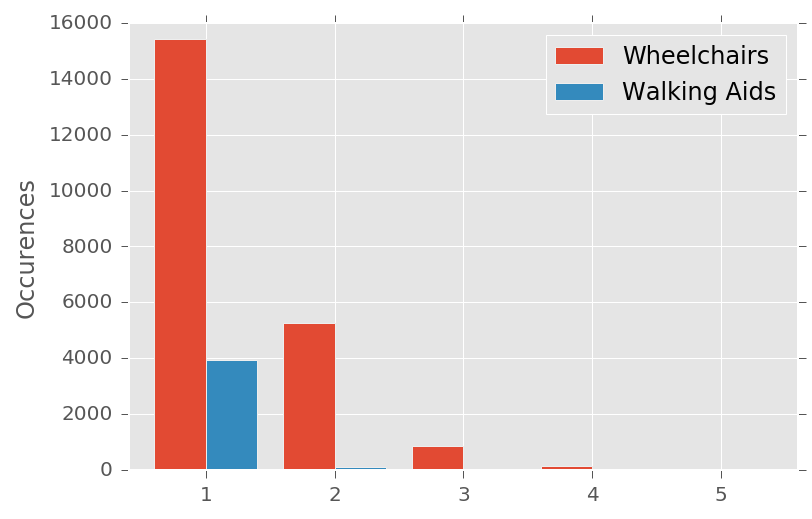

In [18]:
nwc = np.array([len(dets) for dets in tr_wcs])
nwa = np.array([len(dets) for dets in tr_was])
lbplt.showcounts(Counter(nwc[0 < nwc]), Counter(nwa[0 < nwa]),
                 labels=("Wheelchairs", "Walking Aids"), percent=False);

In [19]:
for n in range(1, 5):
    print("Predicting {n} {what} covers {cov:6.1%}".format(cov=np.mean(nwc[0 < nwc] <= n), what="wc", n=n))
print("--")
for n in range(1, 5):
    print("Predicting {n} {what} covers {cov:6.1%}".format(cov=np.mean(nwa[0 < nwa] <= n), what="wa", n=n))
print("--")
for n in range(1, 5):
    print("Predicting {n} covers {cov:6.1%} combined".format(cov=np.mean((nwa+nwc)[0 < (nwa+nwc)] <= n), n=n))

Predicting 1 wc covers  71.3%
Predicting 2 wc covers  95.6%
Predicting 3 wc covers  99.4%
Predicting 4 wc covers 100.0%
--
Predicting 1 wa covers  97.8%
Predicting 2 wa covers 100.0%
Predicting 3 wa covers 100.0%
Predicting 4 wa covers 100.0%
--
Predicting 1 covers  72.1% combined
Predicting 2 covers  95.0% combined
Predicting 3 covers  99.4% combined
Predicting 4 covers  99.8% combined


### Laser scan ranges

Here we look at what `r`, or "distance" values the laser hits, so that we can simultaneously find out about "magic values" as well as see where there's a meaningful cut-off.

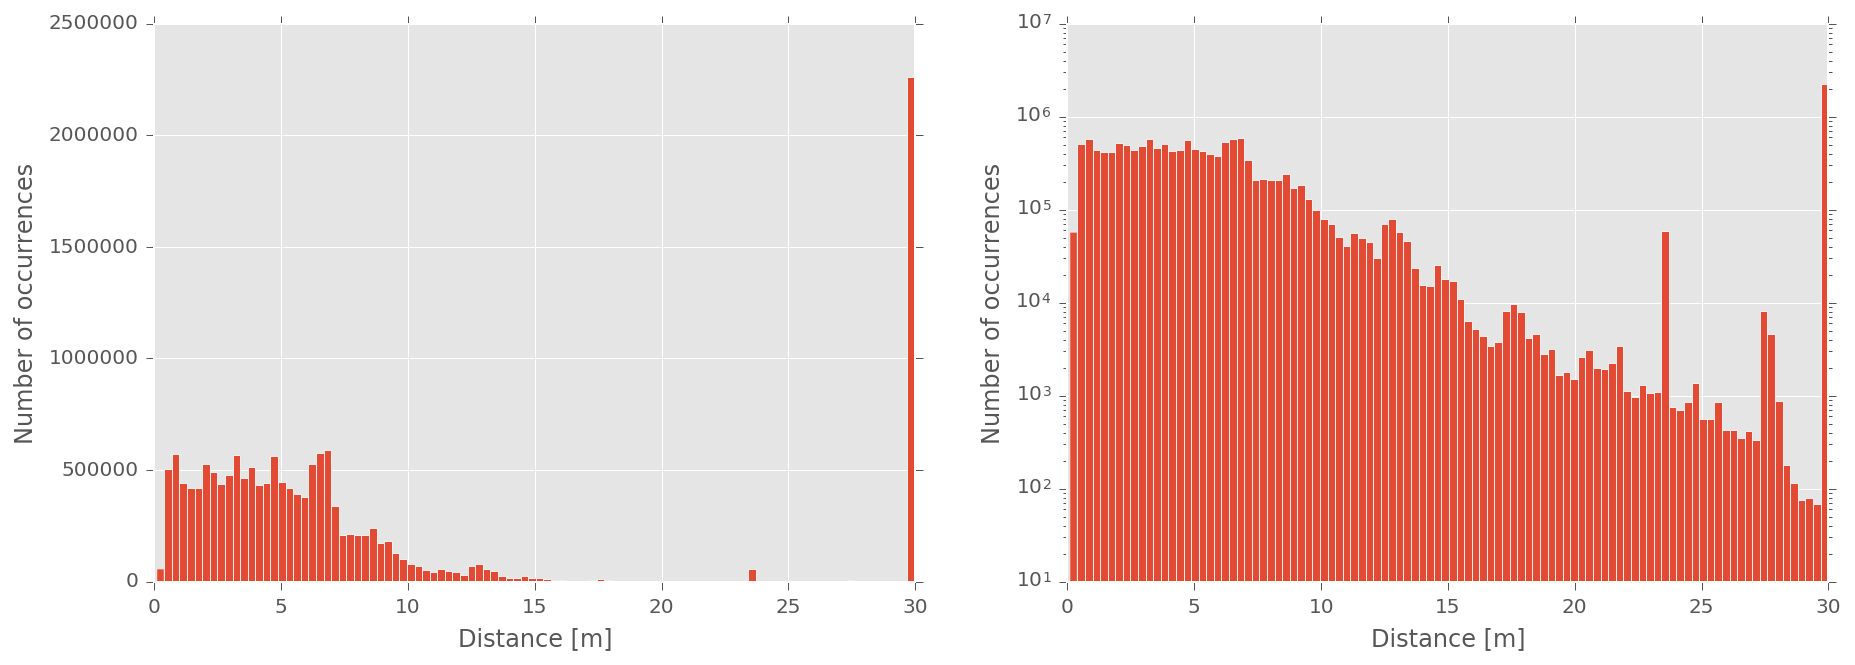

In [20]:
fig, (ax, axlog) = plt.subplots(1, 2, figsize=(15,5))
ax.hist(tr_scans.flatten(), bins=100);
ax.set_ylabel("Number of occurrences")
ax.set_xlabel("Distance [m]")
axlog.hist(tr_scans.flatten(), bins=100, log=True);
axlog.set_ylabel("Number of occurrences")
axlog.set_xlabel("Distance [m]");

We can clearly see the magic `29.96` value also mentioned in the README. However, there's another interesting outlier around 24, which we didn't look into further.

Anyways, the above indicates that we don't lose much data at all by cutting off at a distance of 14/15m.

In [21]:
print("All:  μ={:.2f}, σ={:.2f}".format(np.mean(tr_scans), np.std(tr_scans)))
print("No29: μ={:.2f}, σ={:.2f}".format(np.mean(tr_scans[tr_scans<29.5]), np.std(tr_scans[tr_scans<29.5])))
print("Fun:  μ={:.2f}, σ={:.2f}".format(np.mean(tr_scans/10), np.std(tr_scans/10)))

All:  μ=8.61, σ=9.29
No29: μ=5.07, σ=3.54
Fun:  μ=0.86, σ=0.93


# Plotting

In this section, we define a bunch of plotting functions useful for displaying and inspeciting the data.

Feel free to skip reading this, unless you're curious about matlpotlib, you dirty little sadist.

Although, if you run them, you can interactively scroll through the data, which is pretty cool!
Have a look at, for example, scan number 9575, there's a lot happening there!

In [22]:
def fix_ax(ax, thresh):
    xr, yr = u.scan_to_xy(np.full(100, thresh or 35, dtype=np.float32), thresh)
    ax.set_xlim(np.nanmin(xr), np.nanmax(xr))
    ax.set_ylim(np.nanmin(yr), np.nanmax(yr))

    ax.set_aspect('equal', adjustable='box')
    return ax

In [23]:
def showscan(scan, thresh=14, ax=None, color='#E24A33', alpha=0.33, **figkw):
    x, y = u.scan_to_xy(scan, thresh)
    if ax is None:
        fig, ax = plt.subplots(**figkw)

    # Unfortunately, `scatter` doesn't skip the `color` of `nan` points!
    # So we need to filter those out manually.
    if isinstance(color, (list, tuple, np.ndarray)):
        color = [c for i, c in enumerate(color) if True not in (np.isnan(x[i]), np.isnan(y[i]))]

    ax.scatter(x, y, s=10, color=color, alpha=alpha, lw=0)
    return fix_ax(ax, thresh)

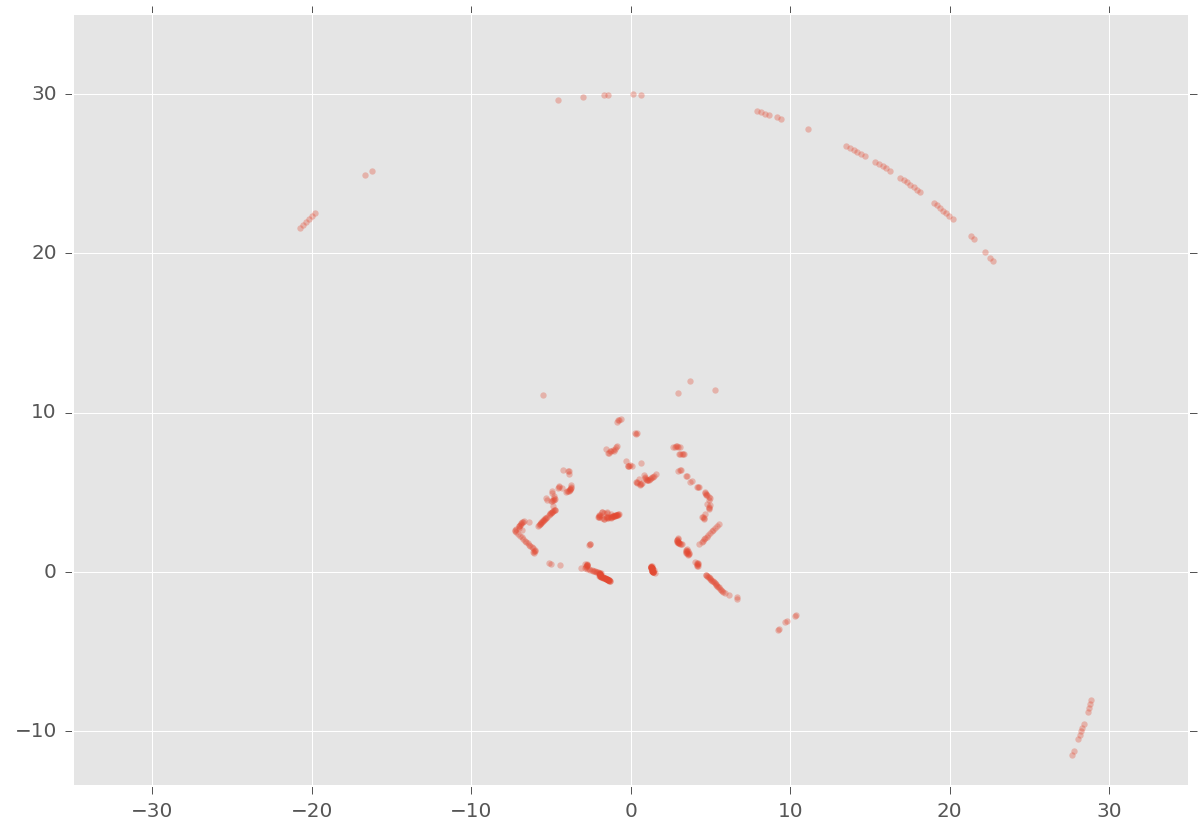

In [24]:
@interact(i=IntSlider(value=0, min=0, max=len(tr_scans)-1, step=1, readout=True, description='Scan', continuous_update=False))
def _foo(i):
    showscan(tr_scans[i], thresh=None, figsize=(10,10))

In [25]:
def showdet(dets, ax=None, figkw={}, **kw):
    # Alternative: '988ED5'
    kw.setdefault('color', '#348ABD')

    if ax is None:
        fig, ax = plt.subplots(**figkw)

    for r, phi in dets:
        x, y = u.rphi_to_xy(r, phi)
        if kw.get('marker') in (None, 'circ'):
            kw.setdefault('alpha', 0.3)
            kw.setdefault('radius', 0.5)
            ax.add_artist(plt.Circle((x,y), **kw))
        else:
            kw.setdefault('linewidths', 2)
            kw.setdefault('s', 50)
            ax.scatter(x, y, **kw)

    return ax

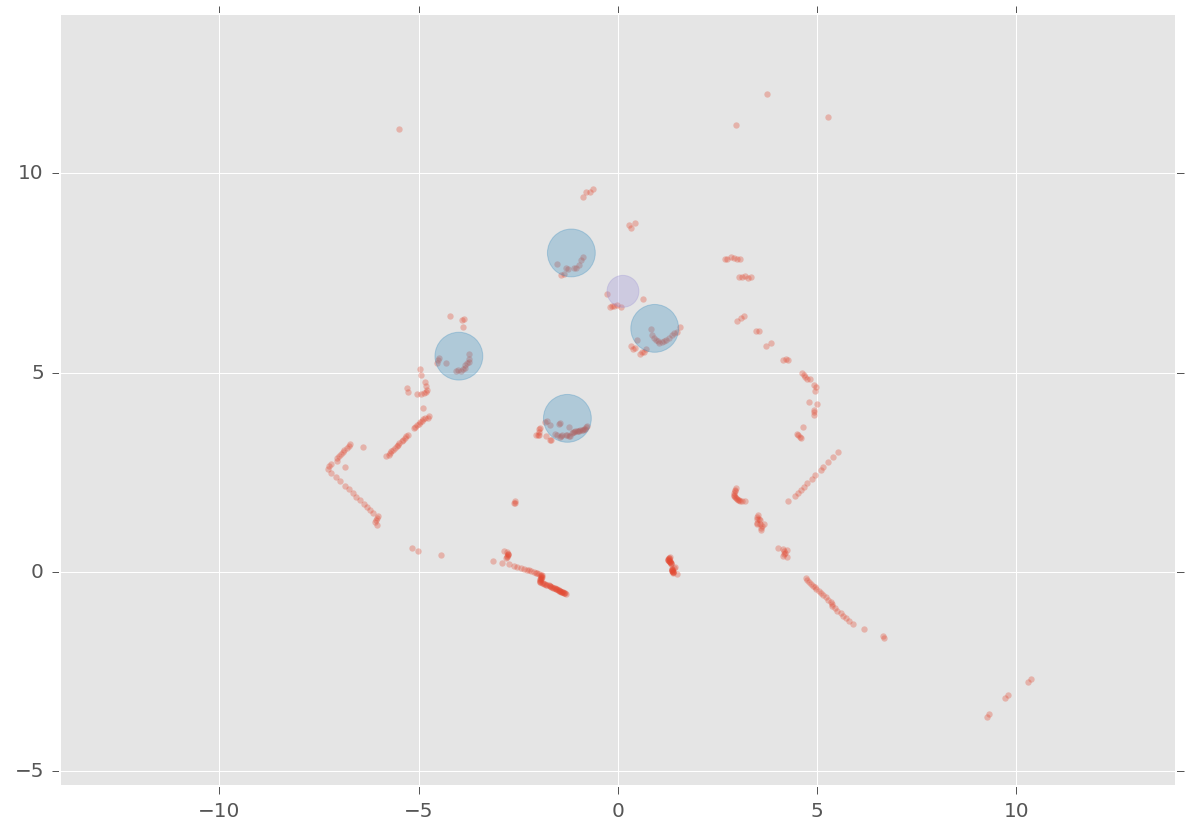

In [26]:
@interact(i=IntSlider(value=0, min=0, max=len(tr_scans)-1, step=1, readout=True, description='Seq', continuous_update=False))
def _foo(i):
    ax = showscan(tr_scans[i], figsize=(10,10))
    showdet(tr_wcs[i], ax, radius=0.6)
    showdet(tr_was[i], ax, radius=0.4, color='#988ED5')

# Learning

## Quick look at cutouts

Let's now have a look at what a preprocessed cut-out around a laser-point, i.e. the actual data the CNN will see as input, looks like. Use the first slider to choose a specific scan, and the second slider to slide through the laser points within that scan. The right plot shows the pre-processed cut-out using various resampling methods (we used `cv` in the paper).

Some particularly interesting ones:
- 9522/91
- 22197/279

/home/beyer/sci-env3.4/lib/python3.4/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/beyer/sci-env3.4/lib/python3.4/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


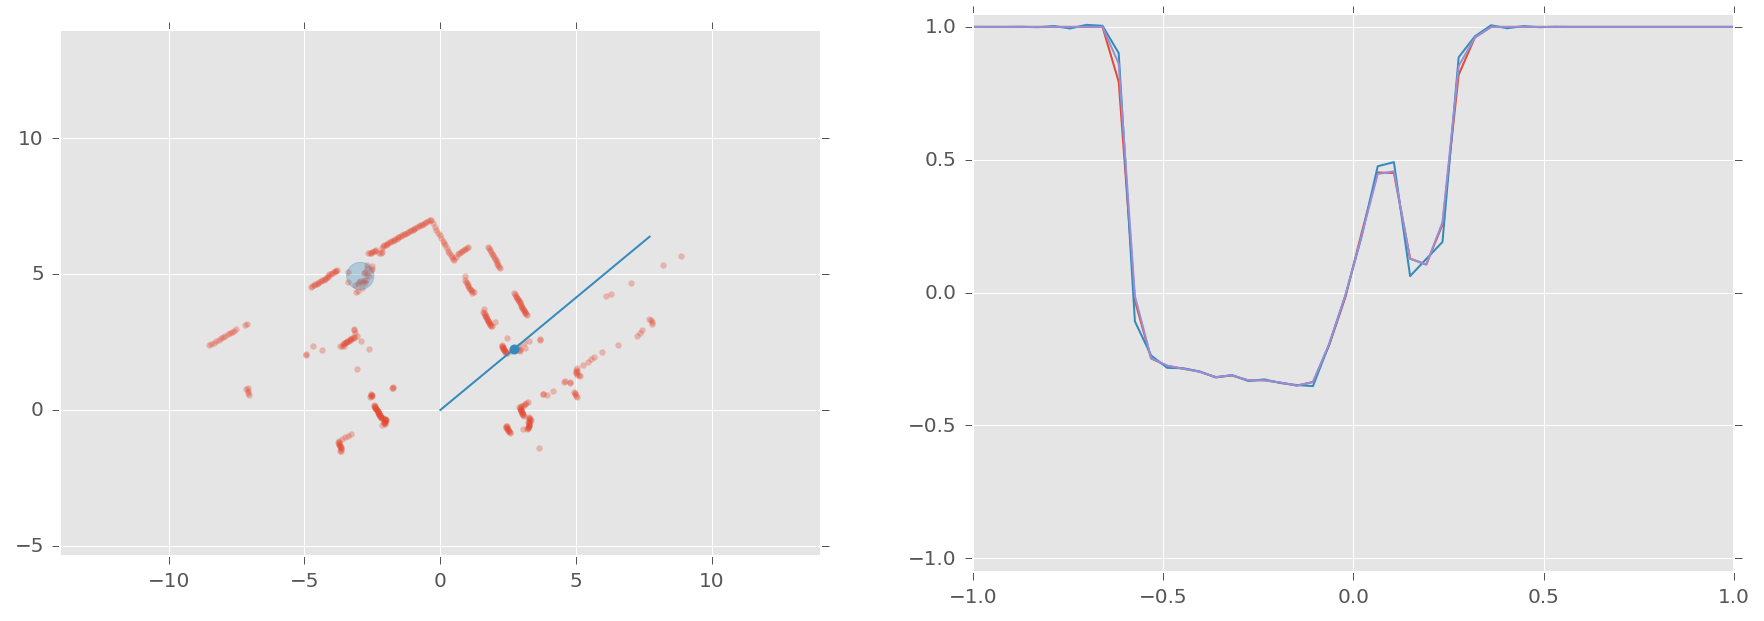

In [27]:
@interact(
    i=IntSlider(value=3554, min=0, max=len(tr_scans)-1, step=1, readout=True, description='Scan', continuous_update=False),
    j=IntSlider(value=124, min=0, max=450-1, readout=True, description='Beam', continuous_update=False)
)
def _foo(i,j):
    fig, (axscan, axwin) = plt.subplots(1,2, figsize=(15,5))
    showscan(tr_scans[i], ax=axscan)
    x , y  = u.rphi_to_xy(10            , u.laser_angles(450)[j])
    xp, yp = u.rphi_to_xy(tr_scans[i][j], u.laser_angles(450)[j])
    axscan.plot([0, x], [0, y], color='#348ABD')
    axscan.scatter(xp, yp, color='#348ABD')
    showdet(tr_wcs[i], axscan)
    showdet(tr_was[i], axscan, color='#988ED5')
    axwin.plot(np.linspace(-1,1, 48), u.generate_cut_outs(tr_scans[i], npts=48, resample_type='cv')[j][::-1], '-')#, label='cv')
    axwin.plot(np.linspace(-1,1, 48), u.generate_cut_outs(tr_scans[i], npts=48, resample_type='zoom', order=5)[j][::-1], '-')#, label='z')
    axwin.plot(np.linspace(-1,1, 48), u.generate_cut_outs(tr_scans[i], npts=48, resample_type='int1d', kind=1)[j][::-1], '-')#, label='1d')
    axwin.legend()
    axwin.set_ylim(-1.05,1.05)

## Data munging again

The result of this data munging is just ALL cutouts and their labels, completely independent of individual scans or sequences. This is the final data-set the CNN learns.

### Depth-invariant windows

You can choose a different "window resolution" by just changing this variable. The following few cells take a little to complete, on my machine it took 5m29s and 1m0s.

In [28]:
win_res = 48

In [29]:
Xtr = np.empty((len(tr_scans), 450, win_res), dtype=df.floatX)
Xva = np.empty((len(va_scans), 450, win_res), dtype=df.floatX)
Xte = np.empty((len(te_scans), 450, win_res), dtype=df.floatX)
Xre = np.empty((len(re_scans), 541, win_res), dtype=df.floatX)
for i, scan in enumerate(tr_scans):
    Xtr[i] = u.generate_cut_outs(scan, npts=win_res)
for i, scan in enumerate(va_scans):
    Xva[i] = u.generate_cut_outs(scan, npts=win_res)
for i, scan in enumerate(te_scans):
    Xte[i] = u.generate_cut_outs(scan, npts=win_res)
for i, scan in enumerate(re_scans):
    Xre[i] = u.generate_cut_outs(scan, npts=win_res)

Xtr = Xtr.reshape((-1, win_res))
Xtr.shape, Xva.shape, Xte.shape, Xre.shape  # Keep test-time ones nicely formed.

((15898500, 48), (3919, 450, 48), (2428, 450, 48), (5000, 541, 48))

### Create targets/labels

Now we need to create the target data for our scans, that's a little involved.
For each individual laser-point, we see if there is a detection nearby (closer than a specific radius, here 0.6 and 0.6) and if so, take the closest one as target. Once we have chosen the target, we need to convert its location into a relative voting location for the current point.

In [32]:
from scipy.spatial.distance import cdist

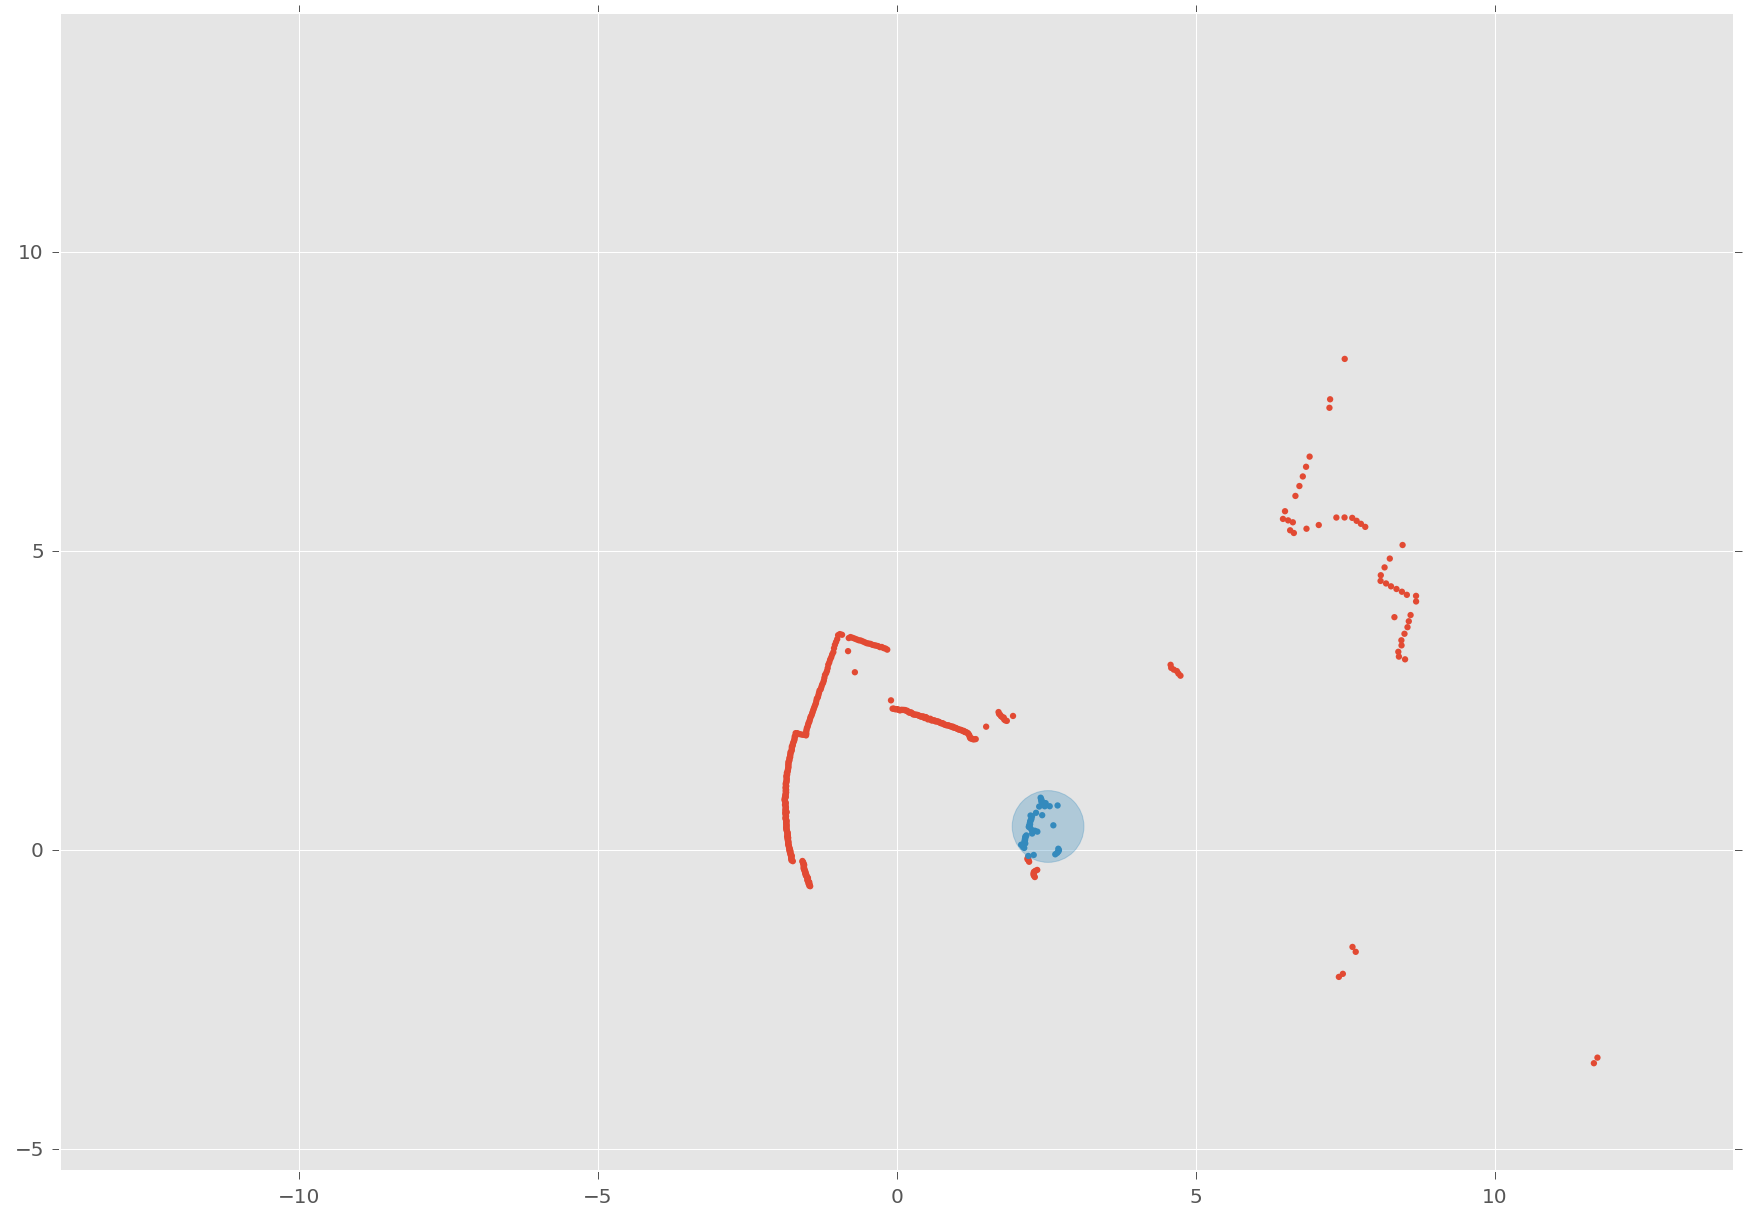

In [33]:
def closest_detection(scan, dets, radii):
    if len(dets) == 0:
        return np.zeros_like(scan, dtype=int)

    assert len(dets) == len(radii), "Need to give a radius for each detection!"

    scan_xy = np.array(u.scan_to_xy(scan)).T

    # Distance (in x,y space) of each laser-point with each detection.
    dists = cdist(scan_xy, np.array([u.rphi_to_xy(x,y) for x,y in dets]))

    # Subtract the radius from the distances, such that they are <0 if inside, >0 if outside.
    dists -= radii

    # Prepend zeros so that argmin is 0 for everything "outside".
    dists = np.hstack([np.zeros((len(scan),1)), dists])

    # And find out who's closest, including the threshold!
    return np.argmin(dists, axis=1)

# Plot it, for testing!
@interact(i=IntSlider(value=16281, min=0, max=len(tr_scans)-1, step=1, readout=True, description='Scan', continuous_update=False))
def _foo(i):
    dets = closest_detection(tr_scans[i], tr_wcs[i] + tr_was[i], [0.6]*len(tr_wcs[i]) + [0.4]*len(tr_was[i]))
    #colors = [['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'][i] for i in dets]
    colors = [(['#E24A33'] + ['#348ABD']*len(tr_wcs[i]) + ['#988ED5']*len(tr_was[i]))[idet] for idet in dets]
    ax = showscan(tr_scans[i], color=colors, alpha=1, figsize=(15,15))
    showdet(tr_wcs[i], ax=ax, radius=0.6);
    showdet(tr_was[i], ax=ax, radius=0.4, color='#988ED5');

In [34]:
def global2win(r, phi, dr, dphi):
    # Convert to relative, angle-aligned x/y coordinate-system.
    dx = np.sin(dphi-phi) * dr
    dy = np.cos(dphi-phi) * dr - r
    return dx, dy

In [35]:
def win2global(r, phi, dx, dy):
    y = r + dy
    dphi = np.arctan2(dx, y)  # dx first is correct due to problem geometry dx -> y axis and vice versa.
    return y/np.cos(dphi), phi + dphi

In [36]:
def generate_votes(scan, wcs, was, rwc=0.6, rwa=0.4):
    N = len(scan)
    y_conf = np.zeros( N, dtype=np.uint32)
    y_offs = np.zeros((N, 2), dtype=df.floatX)

    alldets = list(wcs) + list(was)
    radii = [0.6]*len(wcs) + [0.4]*len(was)
    dets = closest_detection(scan, alldets, radii)
    labels = [0] + [1]*len(wcs) + [2]*len(was)

    for i, (r, phi) in enumerate(zip(scan, u.laser_angles(N))):
        if 0 < dets[i]:
            y_conf[i] = labels[dets[i]]
            y_offs[i,:] = global2win(r, phi, *alldets[dets[i]-1])

    return y_conf, y_offs

ytr_conf, ytr_offs = map(np.concatenate, zip(*list(map(generate_votes, tr_scans, tr_wcs, tr_was))))
print(ytr_conf.shape, ytr_offs.shape)

(15898500,) (15898500, 2)


### Quick look at final training data

In [37]:
print("Class distribution during training:")
print("0/nothing:    {:.2%}".format(np.mean(ytr_conf==0)))
print("1/wheelchair: {:.1%}".format(np.mean(ytr_conf==1)))
print("2/walker:     {:.1%}".format(np.mean(ytr_conf==2)))

Class distribution during training:
0/nothing:    93.06%
1/wheelchair: 6.5%
2/walker:     0.4%


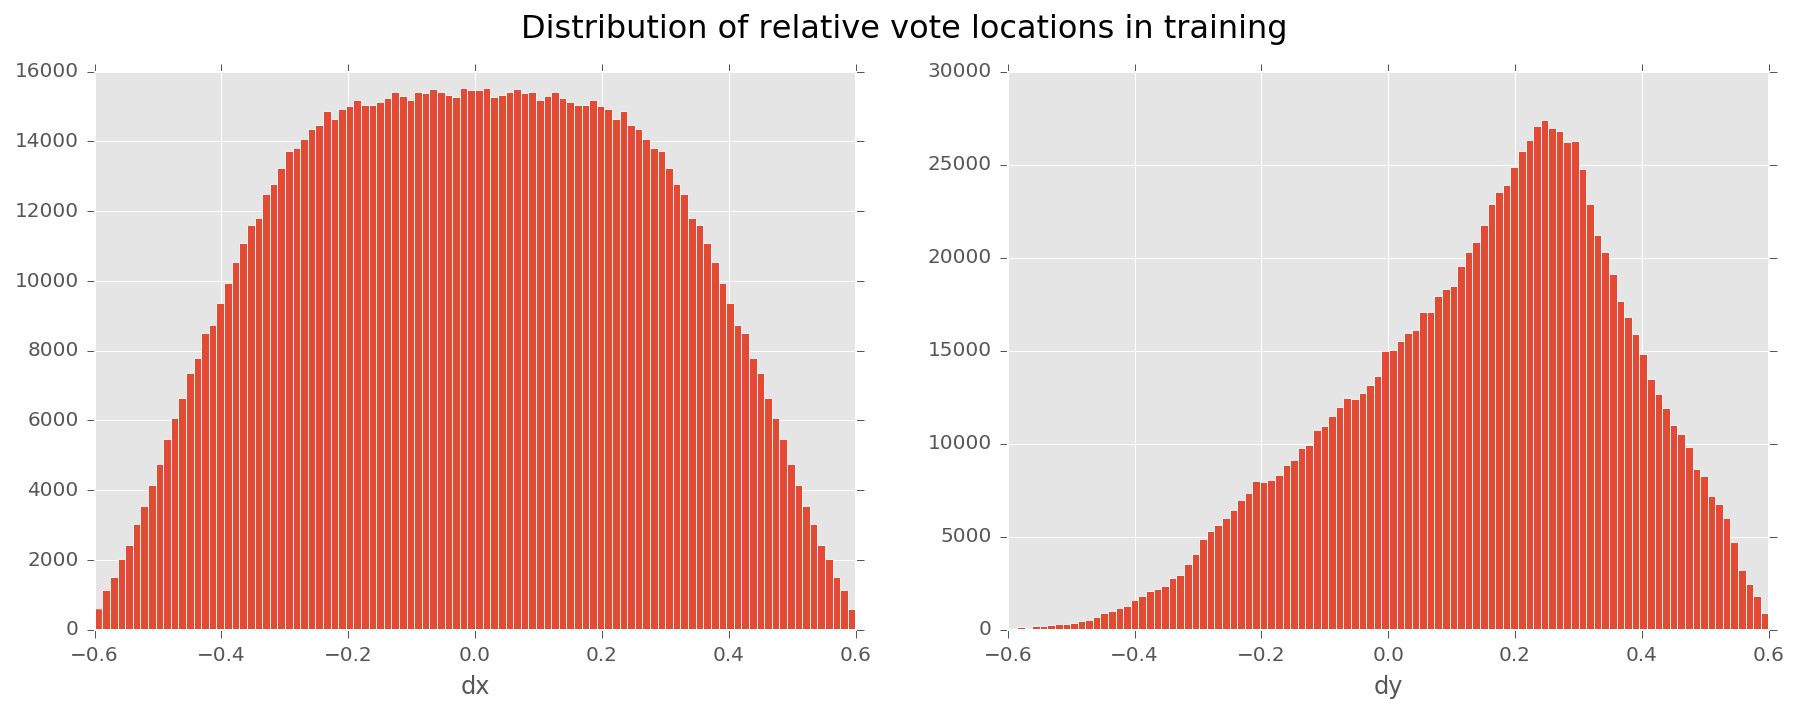

In [38]:
fig, (axtrX, axtrY) = plt.subplots(1,2, figsize=(15,5), sharex=True)
axtrX.hist(ytr_offs[ytr_conf!=0,0], bins=100)
axtrY.hist(ytr_offs[ytr_conf!=0,1], bins=100)
fig.suptitle("Distribution of relative vote locations in training", fontsize=16)
axtrX.set_xlabel('dx')
axtrY.set_xlabel('dy');

## Network

In [127]:
def slot(nin, nout, fs):
    conv = df.SpatialConvolutionCUDNN(nin, nout, (1,fs), border='valid', init=df.init.ortho_svd(), bias=False)
    bn = df.BatchNormalization(nout)
    nl = df.ReLU()
    return conv, bn, nl

In [128]:
def mknet(win_res):
    net = df.Sequential()
    # Add singleton "channel" and singleton "height" dimensions.
    net.add(df.Reshape(-1, 1, 1, win_res))
    net.add(*slot(  1, 64, 5))
    net.add(df.Dropout(0.25))
    net.add(*slot( 64, 64, 5))
    net.add(df.PoolingCUDNN((1,2)))
    net.add(df.Dropout(0.25))

    net.add(*slot( 64, 128, 5))
    net.add(df.Dropout(0.25))
    net.add(*slot(128, 128, 3))
    net.add(df.PoolingCUDNN((1,2)))
    net.add(df.Dropout(0.25))

    net.add(*slot(128, 256, 5))
    net.add(df.Dropout(0.25))
    # Is now (B, 256, 1, 3)

    net.add(
        df.RepeatInput(
            # Confidence
            df.Sequential(
                df.SpatialConvolutionCUDNN(256, 3, (1,3), init=df.init.const(0)),
                df.Reshape(-1, 3),
                df.SoftMax(),
            ),
            # Offset "vote"
            df.Sequential(
                df.SpatialConvolutionCUDNN(256, 2, (1,3), init=df.init.const(0)),
                df.Reshape(-1, 2),
                # I wonder if tanh here makes sense or not,
                # I think not because "very wrong" gets almost 0 gradient too =)
            ),
        )
    )
    lbu.printnow("{:.3f}M params", df.utils.count_params(net)/1000/1000)
    return net
net = mknet(win_res=win_res)

0.280M params

The following compiles the network and runs a forward path with a small batch of data. This way we can already cache the compilation and check that the architecture works, at least in the forward-sense.

That also means it might take a little while to run the first time. (~2m45s for the first run on my computer. Only 18s on the second run though.)

In [129]:
ans = net.forward(Xtr[-128:])
Xtr[-128:].shape, ans[0].shape, ans[1].shape

((128, 48), (128, 3), (128, 2))

## Criterion

Here we build a criterion for both the outputs that we have. The first output is just a regular softmax, so we put a class-NLL criterion on it. The second output is the relative vote offset, on which we put a root mean square error (RMSE) criterion. We enable weighting on the latter, because we only want to apply it for samples which don't belong to the "none" class, so we can set a weight of 0 for samples which do have the "none" class.

In [130]:
def mkcrit():
    return df.ParallelCriterion(
        df.ClassNLLCriterion(),
        df.RMSECriterion(axis=-1).enable_weights(),
    )

crit = mkcrit()

In the following, again, we pre-compile the criteria and send some uninitialized network outputs through them, such that we can judge their order of magnitude.

In [131]:
print(crit.criteria[0][1].forward(ans[0], ytr_conf[-128:].flatten()))
print(crit.criteria[1][1].forward(ans[1], [ytr_offs[-128:], (ytr_conf[-128:] != 0).astype(df.floatX)]))
print(crit.forward(ans, [ytr_conf[-128:].flatten(), [ytr_offs[-128:], (ytr_conf[-128:] != 0).astype(df.floatX)]]))

1.0986123084163681
1.9575849546908866
3.0561972631072547


## Training

In [132]:
opt = df.AdaDelta(0.95)
mon = ReportMonitor("wheelchAI", "drow")

In [133]:
precrecs_during_training = []

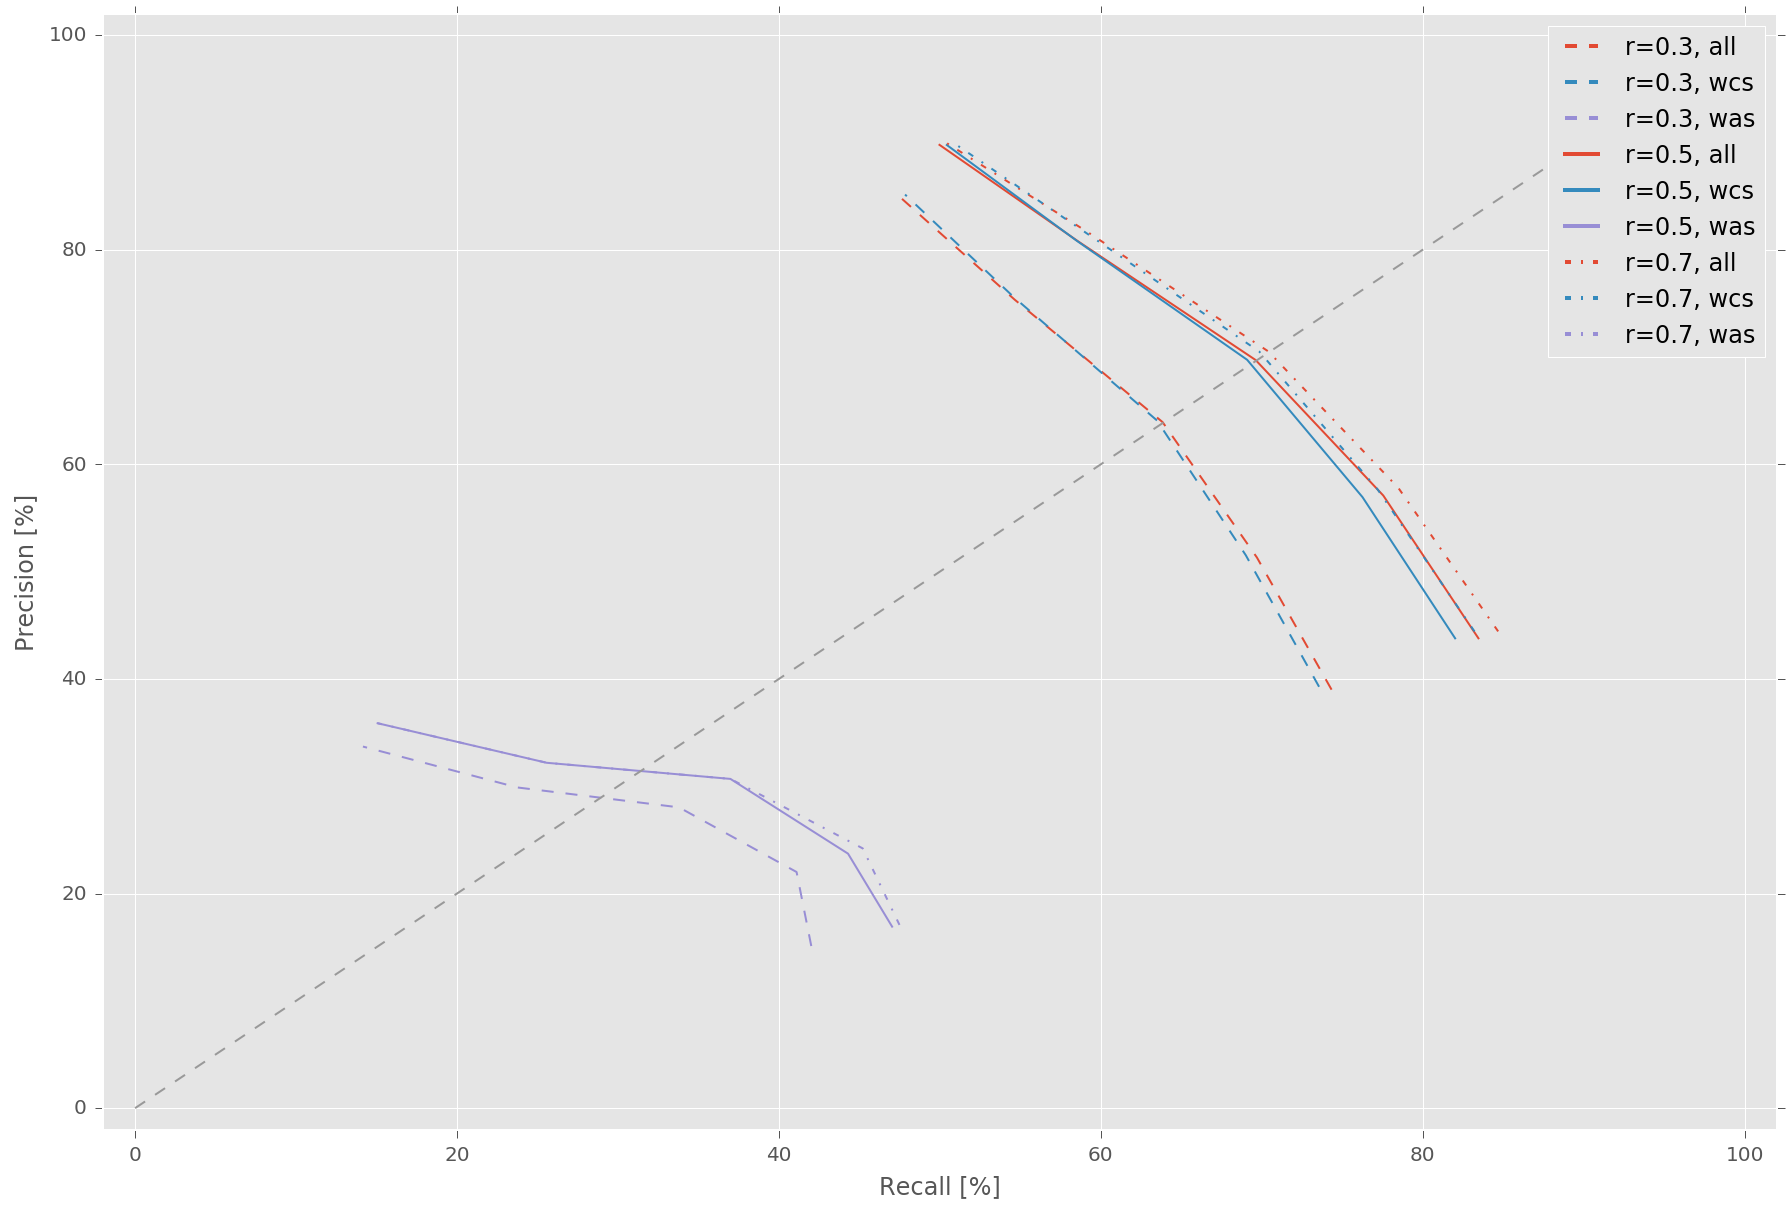

In [152]:
# This uninterrupt thing makes it such that if you press "stop" in the notebook
# then it will still finish the epoch, so that one can easily pause, analyze, and resume.
# Press stop twice to hard-cancel.
with Uninterrupt(verbose=True) as un:
  while not un.interrupted:
    mon.epoch()
    net.training()
    for Xb, yb_conf, yb_offs in lbu.batched(1024, Xtr, ytr_conf, ytr_offs, shuf=True, droplast=True):
        net.zero_grad_parameters()
        tgt_noise = np.exp(np.random.randn(*yb_offs.shape).astype(df.floatX)/20)
        mask = (yb_conf != 0).astype(df.floatX)
        c = net.accumulate_gradients(Xb, [yb_conf.flatten(), [yb_offs*tgt_noise, mask]], crit)
        opt.update_parameters(net)
        mon.loss(float(c))

    # I want to observe how precision and recall curves evolve during training.
    # It will be a unique sighting in the world of computer vision :)

    # But to use the following, you'll first need to run all of the cells below
    # that actually define the functions `compute_precrecs` and `plot_pr_curve`!
    # So here, depending on if these cells were run or not, we either do live-computation
    # and plotting of PR-curves through training, or just print some stuff.
    
    # NOTE: We didn't do that for the paper experiments! For the paper experiments,
    #       we just monitored the loss and that's it. But we put this in the source-release
    #       instead because it's both more interesting *and* more useful in practice.
    #       We'll still plot the loss in a cell below though, for reference.
    try:
        pred2votes
        pred2det_comb
        compute_precrecs
        plot_pr_curve

        for Xb in lbu.batched(20480, Xtr[::4], droplast=True):  # Quarter of the trainset for efficiency reasons.
            net.accumulate_statistics(Xb)

        net.evaluate()
        pred_yva_conf, pred_yva_offs = map(np.array, zip(*[net.forward(Xb) for Xb in Xva]))

        precrecs_during_training.append(
            compute_precrecs(va_scans, pred_yva_conf, pred_yva_offs, va_wcs, va_was,
                ts=(0.1, 0.25, 0.5, 0.75, 0.9),
                rs=(0.3, 0.5, 0.7)
            )
        )

        lbplt.liveplot(lambda *a: plot_pr_curve(*a, radii=(0.3, 0.5, 0.7))[0], *precrecs_during_training[-1])
    except NameError:
        print("Epoch {} (Run the cells defining `pred2votes`, `pred2det_comb`, "
              "`compute_precrecs`, and `plot_pre_curve` first to have a live-plot)".format(mon._e()))

Save both the PR curves over time and the network parameters for the future.

In [ ]:
np.savez("/home/beyer/reports/wheelchAI/pr-val-curves.npz", precrecs_during_training)

The following can be used to scroll through the PR curves retrospectively. I'll leave it at the first one, i.e. what it looks like after one epoch of training.

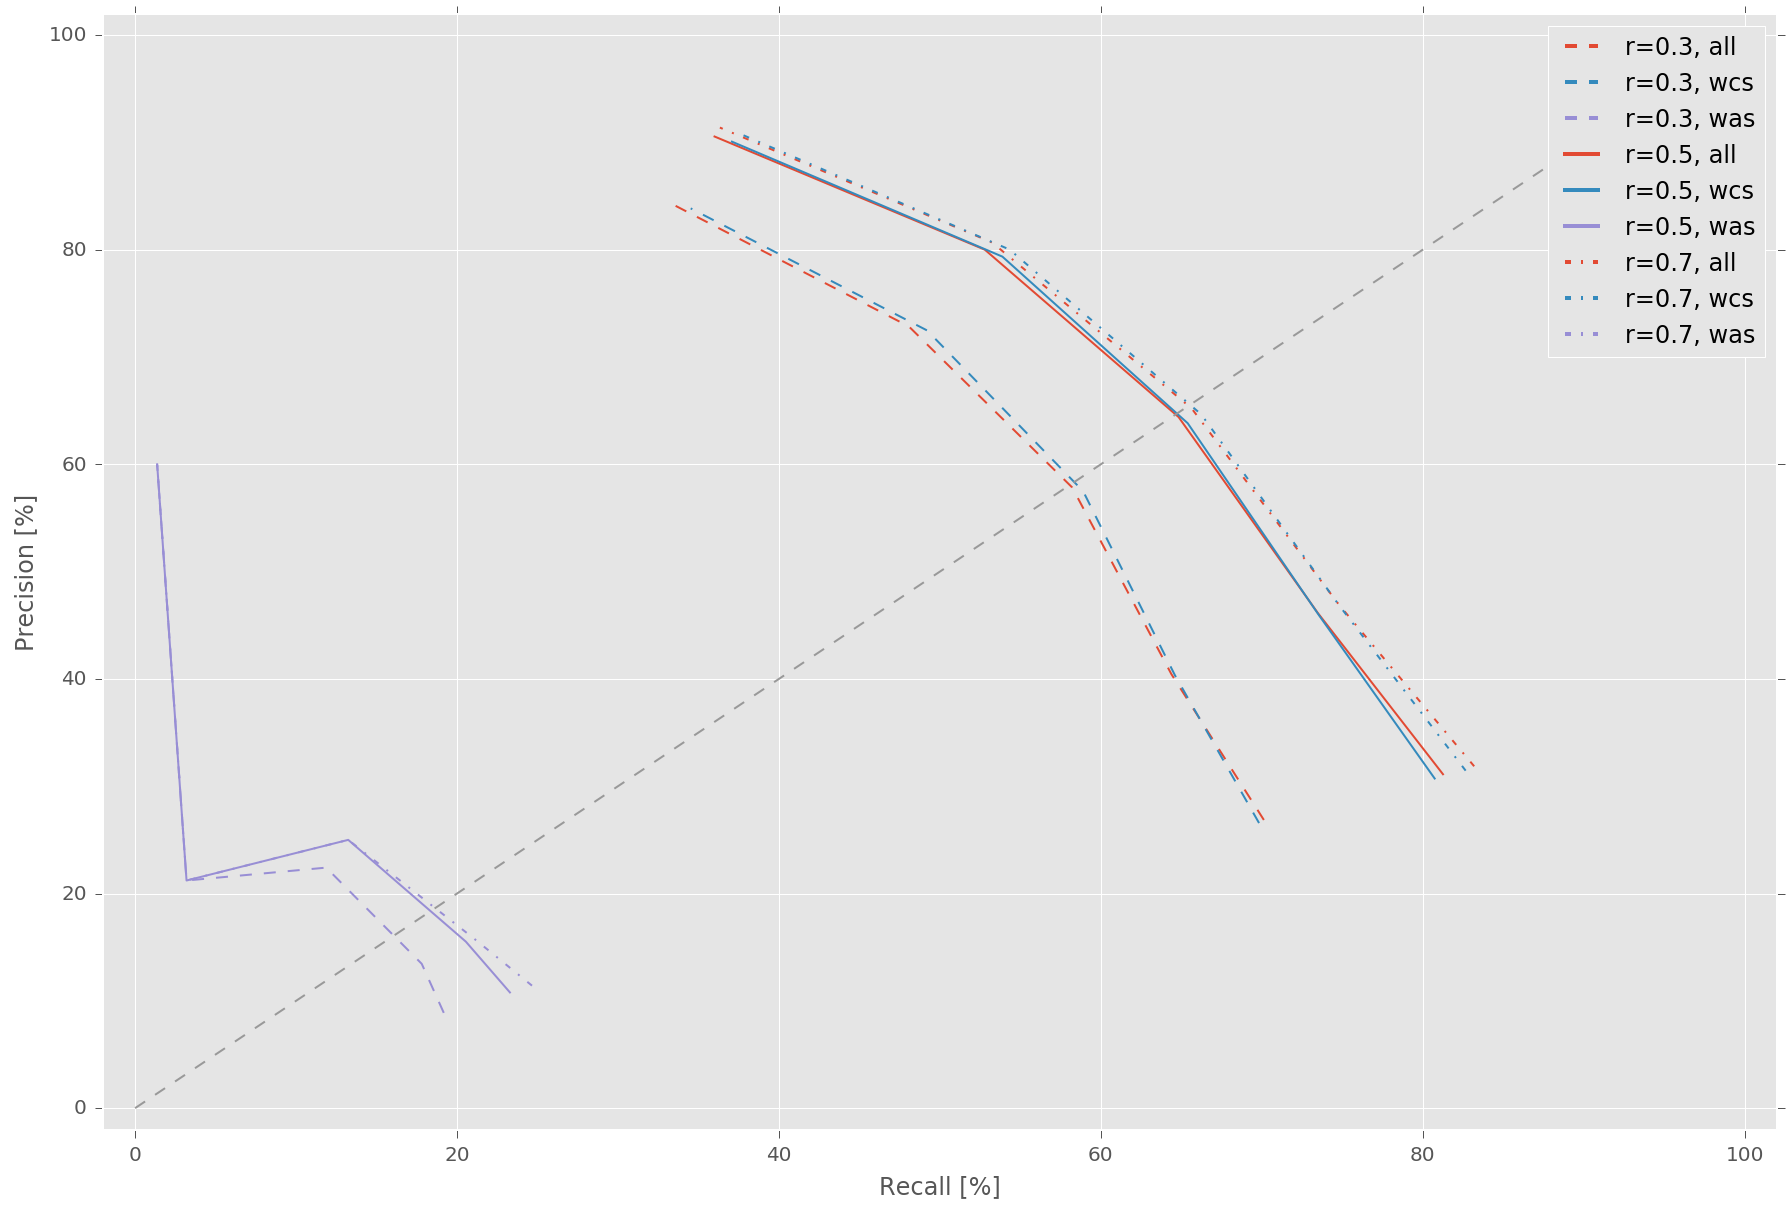

In [154]:
@interact(i=IntSlider(value=1, min=1, max=len(precrecs_during_training2), step=1, readout=True, description='Epoch', continuous_update=False))
def foo(i):
    plot_pr_curve(*precrecs_during_training2[i-1], radii=(0.3, 0.5, 0.7));

Once we're done with training, collect the full trainset batch-norm statistics.

In [123]:
net.training()
for Xb in lbu.batched(20480, Xtr, droplast=True):
    net.accumulate_statistics(Xb)

In [162]:
np.savez("/home/beyer/reports/wheelchAI/wcnet-final.npz", net.__getstate__())

## Prediction

Now, let's first send all the data through the trained network so we can have a look at that and fully evaluate it. Again, this can take a little while, especially given the size of the training-set! (3m47s on my machine)

In [155]:
net.evaluate()
pred_ytr_conf, pred_ytr_offs = map(np.array, zip(*[net.forward(Xb) for Xb in Xtr.reshape((-1, 450, win_res))]))
pred_yva_conf, pred_yva_offs = map(np.array, zip(*[net.forward(Xb) for Xb in Xva]))
pred_yte_conf, pred_yte_offs = map(np.array, zip(*[net.forward(Xb) for Xb in Xte]))
pred_yre_conf, pred_yre_offs = map(np.array, zip(*[net.forward(Xb) for Xb in Xre]))

print(pred_ytr_conf.shape, pred_ytr_offs.shape)
print(pred_yva_conf.shape, pred_yva_offs.shape)
print(pred_yte_conf.shape, pred_yte_offs.shape)
print(pred_yre_conf.shape, pred_yre_offs.shape)

(35330, 450, 3) (35330, 450, 2)
(3919, 450, 3) (3919, 450, 2)
(2428, 450, 3) (2428, 450, 2)
(5000, 541, 3) (5000, 541, 2)


The following shows the distribution of the softmax output over the different datasets and classes.
What we can see is that the network is not confident about walkers at all, and that the network gets very confident at saying "nothing" but not too confident at saying "yes", not even on the train-set (an indication that it didn't overfit to the train-set.)

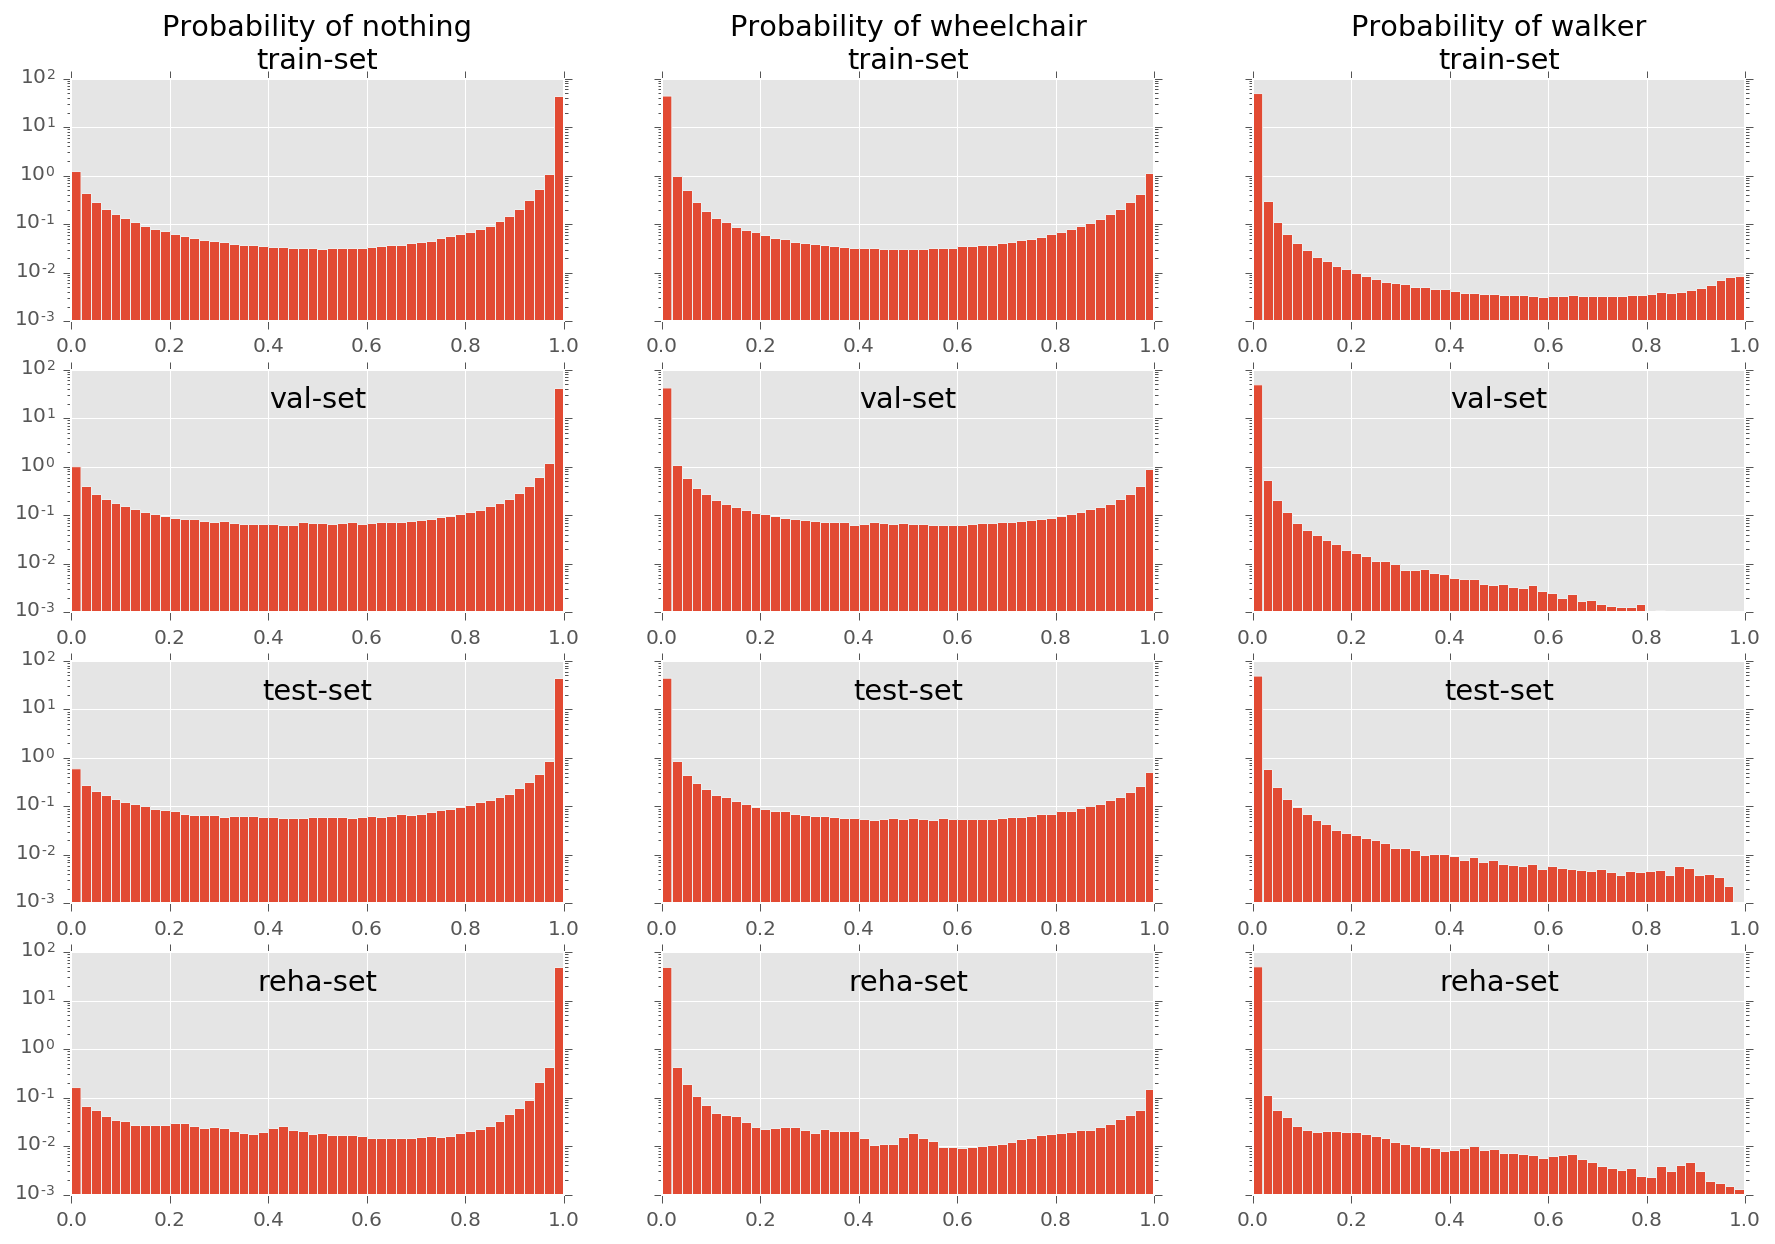

In [161]:
fig, axes = plt.subplots(4,3, figsize=(15,10), sharey=True)
axes[0,0].hist(pred_ytr_conf[...,0].flatten(), bins=50, log=True, normed=True);
axes[0,0].set_title("Probability of nothing\ntrain-set")
axes[0,1].hist(pred_ytr_conf[...,1].flatten(), bins=50, log=True, normed=True);
axes[0,1].set_title("Probability of wheelchair\ntrain-set")
axes[0,2].hist(pred_ytr_conf[...,2].flatten(), bins=50, log=True, normed=True);
axes[0,2].set_title("Probability of walker\ntrain-set")
axes[1,0].hist(pred_yva_conf[...,0].flatten(), bins=50, log=True, normed=True);
axes[1,0].set_title("val-set", y=0.8)
axes[1,1].hist(pred_yva_conf[...,1].flatten(), bins=50, log=True, normed=True);
axes[1,1].set_title("val-set", y=0.8)
axes[1,2].hist(pred_yva_conf[...,2].flatten(), bins=50, log=True, normed=True);
axes[1,2].set_title("val-set", y=0.8)
axes[2,0].hist(pred_yte_conf[...,0].flatten(), bins=50, log=True, normed=True);
axes[2,0].set_title("test-set", y=0.8)
axes[2,1].hist(pred_yte_conf[...,1].flatten(), bins=50, log=True, normed=True);
axes[2,1].set_title("test-set", y=0.8)
axes[2,2].hist(pred_yte_conf[...,2].flatten(), bins=50, log=True, normed=True);
axes[2,2].set_title("test-set", y=0.8)
axes[3,0].hist(pred_yre_conf[...,0].flatten(), bins=50, log=True, normed=True);
axes[3,0].set_title("reha-set", y=0.8)
axes[3,1].hist(pred_yre_conf[...,1].flatten(), bins=50, log=True, normed=True);
axes[3,1].set_title("reha-set", y=0.8)
axes[3,2].hist(pred_yre_conf[...,2].flatten(), bins=50, log=True, normed=True);
axes[3,2].set_title("reha-set", y=0.8);

And now look at the distribution of votes for those points where the network is confident that there is something. The first row shows the ground-truth on the train-set, the following four show the predictions on the train, val, test, reha sets.

What's interesting to see here, is that it's pretty symmetrical along `dx` (expected), the `dy` votes are very biased positively. Thinking about it, it means the wheelchairs/walkers usually lie farther away from the robot than the laser point itself, which makes sense.

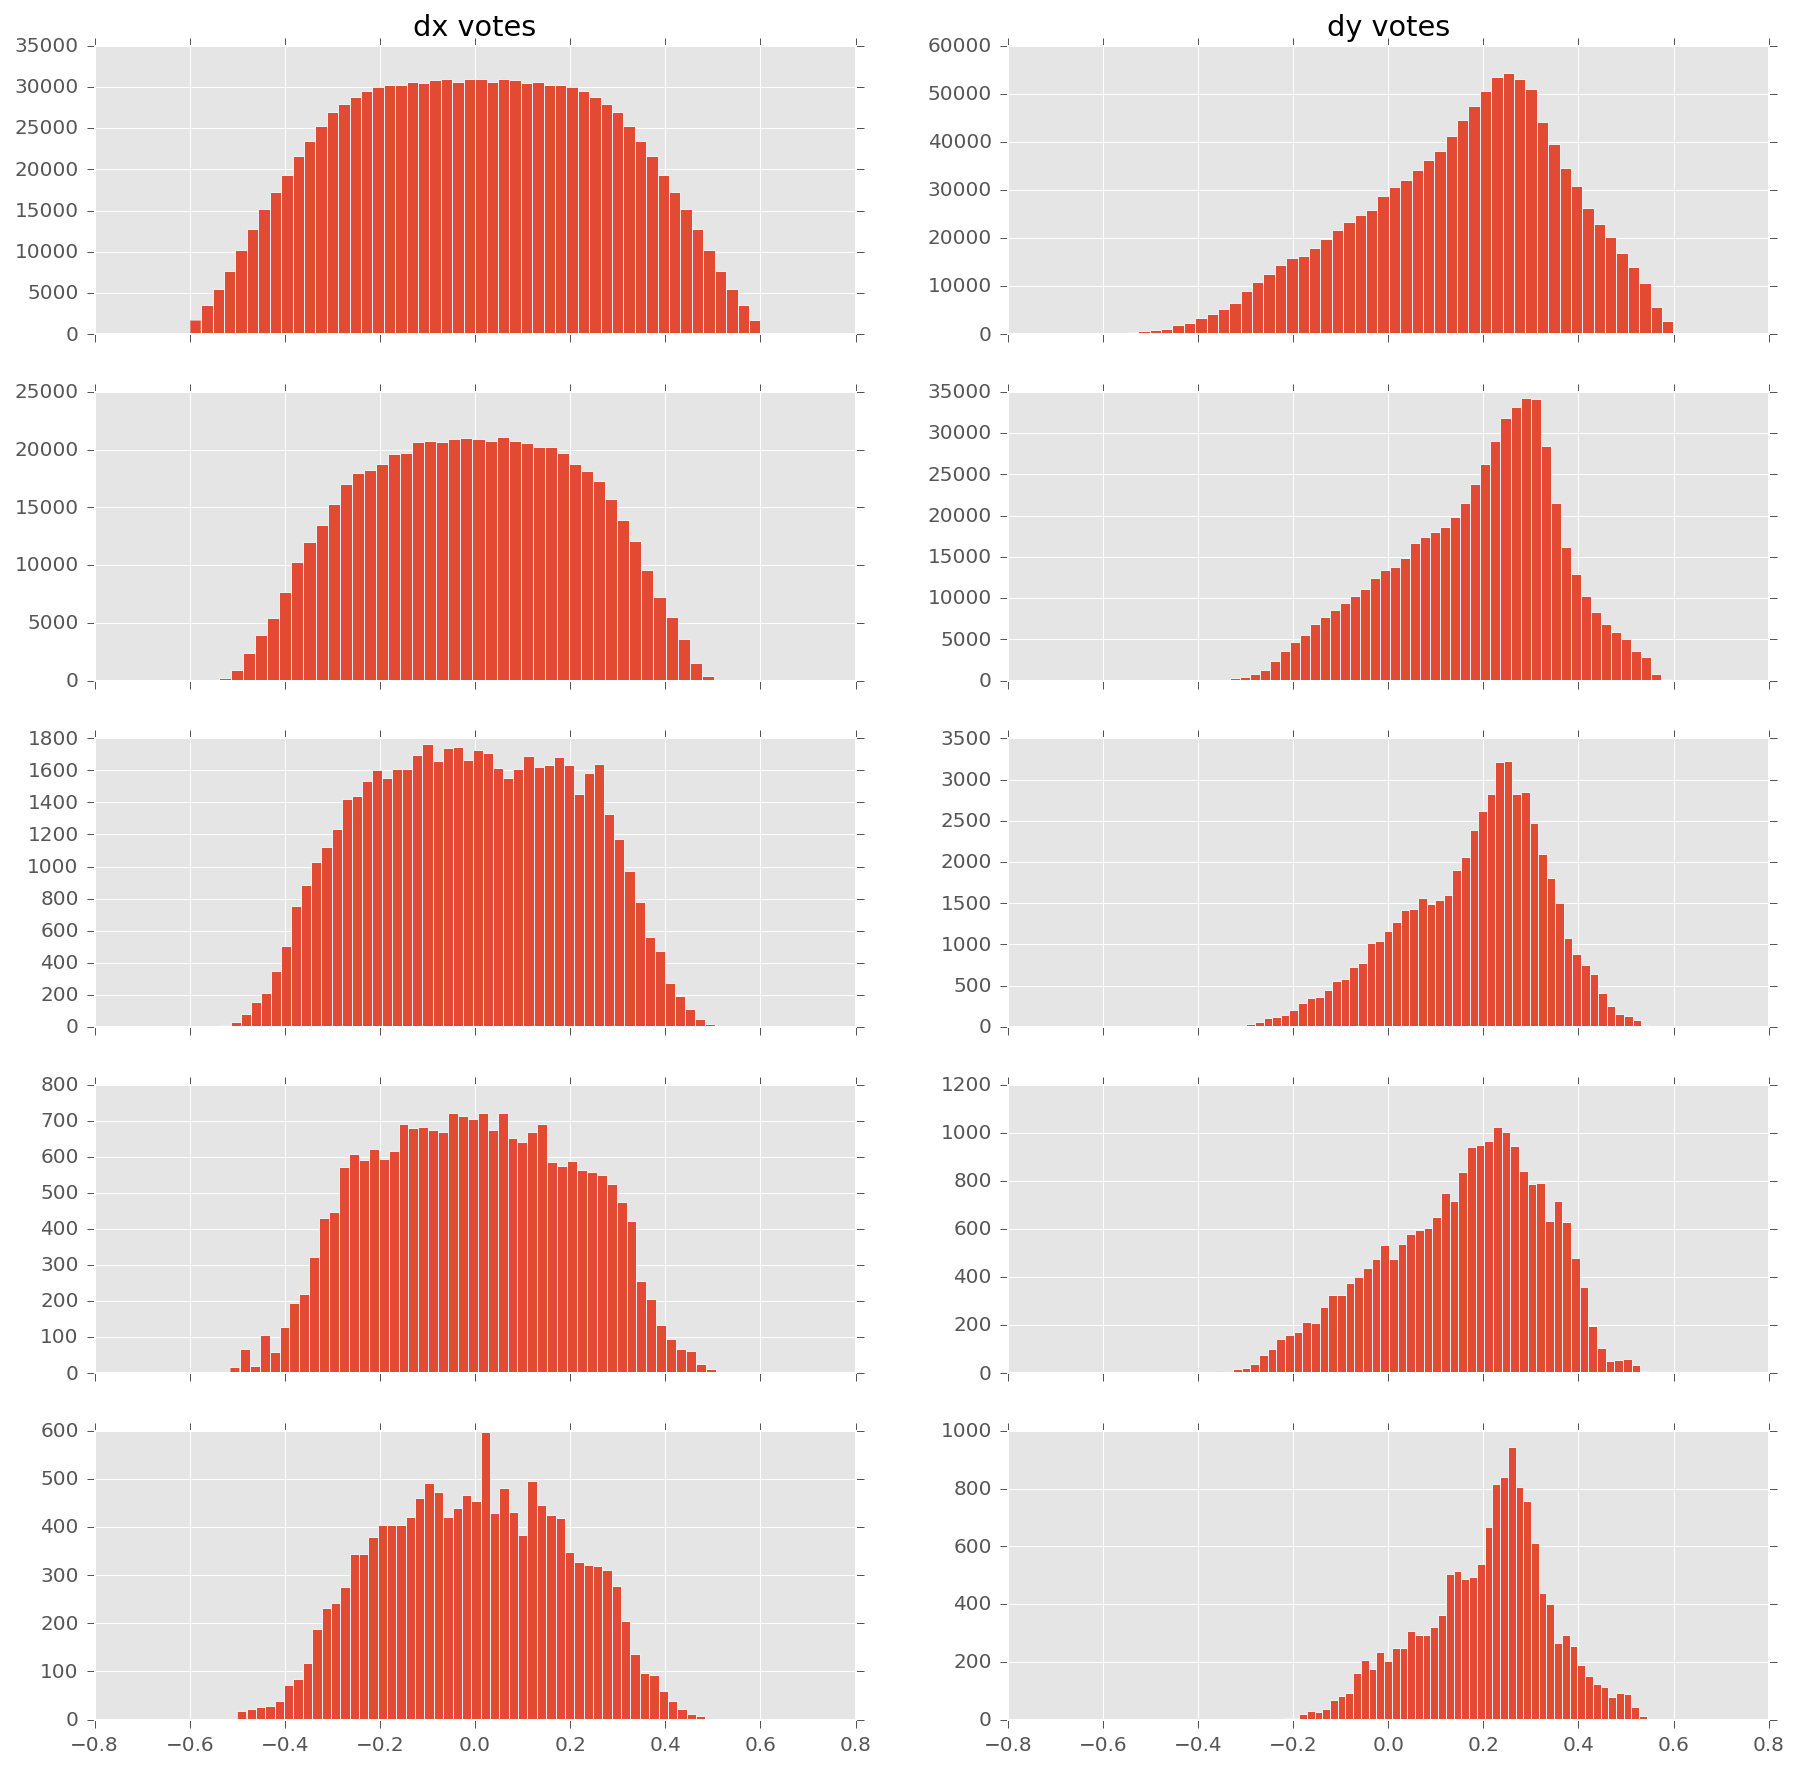

In [163]:
fig, axes = plt.subplots(5,2, figsize=(15,15), sharex=True)
axes[0,0].set_title("dx votes")
axes[0,1].set_title("dy votes")
axes[0,0].hist(     ytr_offs[...,0][ytr_offs[...,0] != 0], bins=50, log=False, normed=False);
axes[0,1].hist(     ytr_offs[...,1][ytr_offs[...,1] != 0], bins=50, log=False, normed=False);
axes[1,0].hist(pred_ytr_offs[...,0][pred_ytr_conf[...,0] < 0.05].flatten(), bins=50, log=False, normed=False);
axes[1,1].hist(pred_ytr_offs[...,1][pred_ytr_conf[...,0] < 0.05].flatten(), bins=50, log=False, normed=False);
axes[2,0].hist(pred_yva_offs[...,0][pred_yva_conf[...,0] < 0.05].flatten(), bins=50, log=False, normed=False);
axes[2,1].hist(pred_yva_offs[...,1][pred_yva_conf[...,0] < 0.05].flatten(), bins=50, log=False, normed=False);
axes[3,0].hist(pred_yte_offs[...,0][pred_yte_conf[...,0] < 0.05].flatten(), bins=50, log=False, normed=False);
axes[3,1].hist(pred_yte_offs[...,1][pred_yte_conf[...,0] < 0.05].flatten(), bins=50, log=False, normed=False);
axes[4,0].hist(pred_yre_offs[...,0][pred_yre_conf[...,0] < 0.05].flatten(), bins=50, log=False, normed=False);
axes[4,1].hist(pred_yre_offs[...,1][pred_yre_conf[...,0] < 0.05].flatten(), bins=50, log=False, normed=False);

### From net output to votes

We now need to convert the network-output to vote locations in full-scan coordinates. The following does so, and also visualizes them.

In [164]:
# Little utility which helps visualizing the ground-truth.
def onehot2conf(onehot, K):
    if isinstance(onehot, (list, np.ndarray)):
        N = len(onehot)
        p = np.zeros((N, K), df.floatX)
        p[np.arange(N), onehot] = 1
    else:
        p = np.zeros(K, df.floatX)
        p[onehot] = 1
    return p

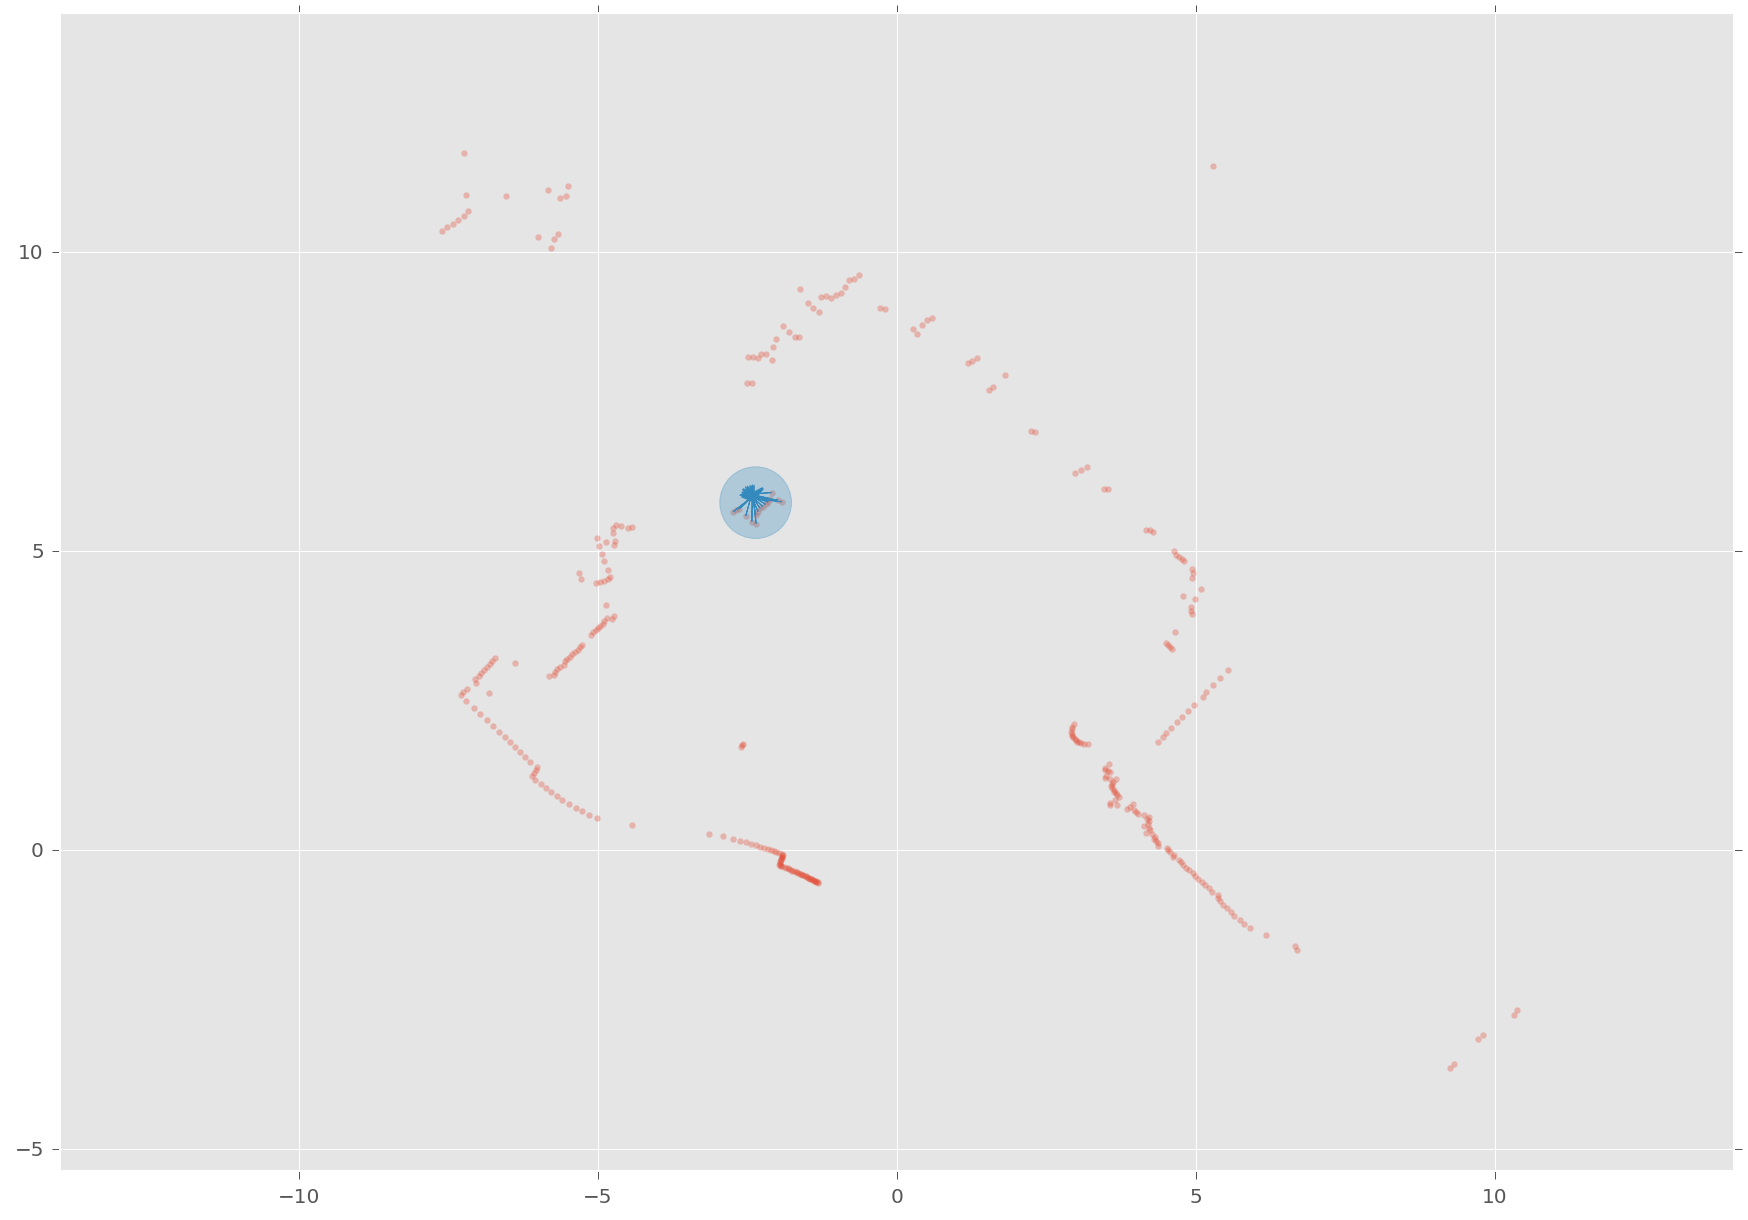

In [165]:
def showvotes(scan, y_conf, y_offs, thresh, ax=None, figkw={}, **arrowkw):
    if ax is None:
        fig, ax = plt.subplots(**figkw)

    arrowkw.setdefault('head_width', 0.1)
    arrowkw.setdefault('head_length', 0.2)

    for (pno, pwc, pwa), (dx, dy), r, phi in zip(y_conf, y_offs, scan, u.laser_angles(len(scan))):
        if pwc+pwa < thresh:
            continue

        # Get the vote absolute location relative to robot (0,0)
        vr, vphi = win2global(r, phi, dx, dy)
        vx, vy = u.rphi_to_xy(vr, vphi)

        x, y = u.rphi_to_xy(r, phi)
        c = ['#348ABD', '#988ED5'][pwc < pwa]

        kw = dict(**arrowkw)
        kw.setdefault('fc', c)
        kw.setdefault('ec', c)
        ax.arrow(x,y, vx-x, vy-y, **kw)

    return ax

@interact(
    i=IntSlider(value=9522, min=0, max=len(tr_scans)-1, step=1, readout=True, description='Scan', continuous_update=False),
    #i=IntSlider(value=0, min=0, max=len(va_scans)-1, step=1, readout=True, description='Scan', continuous_update=False),
    #i=IntSlider(value=0, min=0, max=len(te_scans)-1, step=1, readout=True, description='Scan', continuous_update=False),
    t=FloatSlider(value=0.5, min=0, max=1, step=0.01, readout=True, description='Thresh', continuous_update=False),
)
def _foo(i,t):
    ax = showscan(tr_scans[i], figsize=(15,15))
    showdet(tr_wcs[i], ax, radius=0.6)
    showdet(tr_was[i], ax, radius=0.4, color='#988ED5')
    showvotes(tr_scans[i], pred_ytr_conf[i], pred_ytr_offs[i], thresh=t, ax=ax)
    #showvotes(tr_scans[i], onehot2conf(ytr_conf.reshape((-1, 450))[9522], 3), ytr_offs.reshape((-1, 450, 2))[i], thresh=t, ax=ax)

    #ax = showscan(va_scans[i], figsize=(15,15))
    #showdet(va_wcs[i], ax, radius=0.6)
    #showdet(va_was[i], ax, radius=0.4, color='#988ED5')
    #showvotes(va_scans[i], pred_yva_conf[i], pred_yva_offs[i], thresh=t, ax=ax)

    #ax = showscan(te_scans[i], figsize=(15,15))
    #showdet(te_wcs[i], ax, radius=0.6)
    #showdet(te_was[i], ax, radius=0.4, color='#988ED5')
    #showvotes(te_scans[i], pred_yte_conf[i], pred_yte_offs[i], thresh=t, ax=ax)

In [166]:
def pred2votes(scan, y_conf, y_offs, thresh):
    locs, probs = [], []
    for (pno, pwc, pwa), (dx, dy), r, phi in zip(y_conf, y_offs, scan, u.laser_angles(len(scan))):
        if thresh < pwc+pwa:
            locs.append(u.rphi_to_xy(*win2global(r, phi, dx, dy)))
            probs.append((pwc, pwa))
    return locs, probs

In [167]:
%%timeit
pred2votes(tr_scans[9522], pred_ytr_conf[9522], pred_ytr_offs[9522], thresh=0.5);

100 loops, best of 3: 1.45 ms per loop


### From votes to dets (NMS)

This is a cheap way to perform non-maximum suppression, as detailed in the paper.

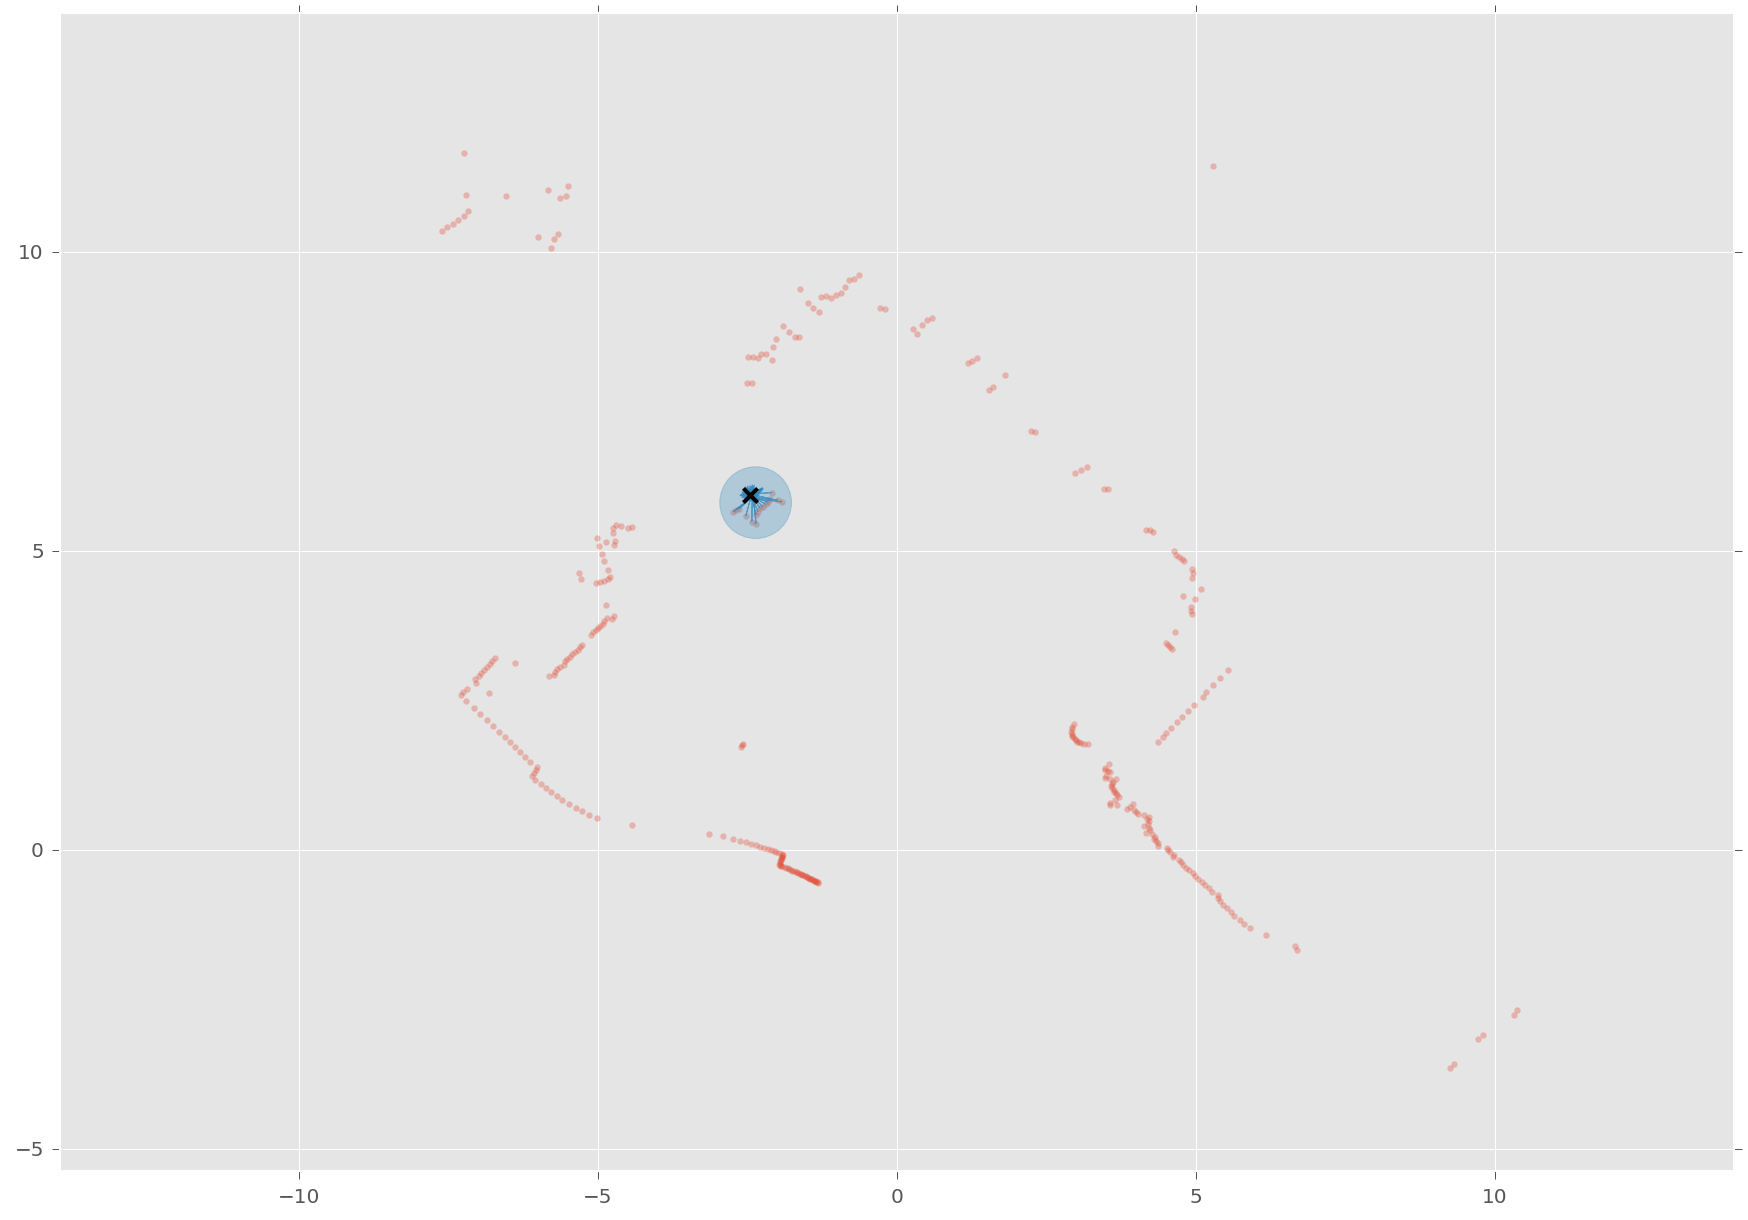

In [168]:
@interact(
    i=IntSlider(value=9600, min=0, max=len(tr_scans)-1, step=1, readout=True, description='Scan', continuous_update=False),
    t=FloatSlider(value=0.5, min=0, max=1, step=0.01, readout=True, description='Thresh', continuous_update=False),
    a=FloatSlider(value=0.7, min=0, max=1, step=0.01, readout=True, description='Vote alpha', continuous_update=False),
)
def _foo(i,t,a):
    ax = showscan(tr_scans[i], figsize=(15,15))
    showdet(tr_wcs[i], ax, radius=0.6)
    showdet(tr_was[i], ax, radius=0.4, color='#988ED5')
    showvotes(tr_scans[i], pred_ytr_conf[i], pred_ytr_offs[i], thresh=t, ax=ax, alpha=a)

    locs, probs = pred2votes(tr_scans[i], pred_ytr_conf[i], pred_ytr_offs[i], thresh=t)
    for x, y, lbl in u.votes_to_detections(locs, probs, in_rphi=False, out_rphi=False):
        showdet([u.xy_to_rphi(x,y)], ax, marker=['x', '+'][lbl], color='black', zorder=5)#color=['#348ABD', '#988ED5'][lbl])

In [169]:
def pred2det_comb(scans, confs, offss, thresh, out_rphi=True):
    K = confs.shape[2] - 1  # Minus the "nothing" type.
    dets_all = []                  # All detections combined, regardless of type.
    dets = [[] for _ in range(K)]  # All detections of each type

    for scan, conf, offs in zip(scans, confs, offss):
        dall, d = [], [[] for _ in range(K)]

        locs, probs = pred2votes(scan, conf, offs, thresh=thresh)
        for x, y, lbl in u.votes_to_detections(locs, probs, in_rphi=False, out_rphi=out_rphi):
            dall.append((x,y))
            d[lbl].append((x,y))
        dets_all.append(dall)
        for k in range(K):
            dets[k].append(d[k])

    return dets_all, dets

In [170]:
%%timeit
pred2det_comb(tr_scans[9522:9523], pred_ytr_conf[9522:9523], pred_ytr_offs[9522:9523], thresh=0.5)

100 loops, best of 3: 9.72 ms per loop


Could be faster, but oh well.

## Precision/Recall

In [ ]:
!pwd

**IMPORTANT NOTE**: These evaluations do not include hyperopt optimized parameters and as such are not the exact same as in the paper. Instead, we should be using the various functions from the `utils.py` file/library.

I didn't get around to updating the notebook to use them, especially because I wanted to keep the nice investigative/interactive visualizations which help clarify a lot of things IMO. So the following is older code from before that happened.

The following is not that useful for deployment anymore, but very important for papers: computation of precision-recall curves!

In [171]:
def compute_precrecs(
    scans, pred_conf, pred_offs, gt_wcs, gt_was,
    ts=(1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1-1e-3, 1-1e-5),
    rs=(0.1, 0.3, 0.5, 0.7, 0.9)
):
    gt_all = [wcs+was for wcs, was in zip(gt_wcs, gt_was)]

    if isinstance(rs, (float, int)):
        rs = (rs,)

    mkgt = lambda: np.full((len(ts), len(rs)), np.nan)
    precs   , recs    = mkgt(), mkgt()
    precs_wc, recs_wc = mkgt(), mkgt()
    precs_wa, recs_wa = mkgt(), mkgt()

    for i, t in enumerate(ts):
        alldets, (wcdets, wadets) = pred2det_comb(scans, pred_conf, pred_offs, thresh=t, out_rphi=False)
        for j, r in enumerate(rs):
            precs[i,j], recs[i,j] = u.precrec(alldets, gt_all, r, pred_rphi=False, gt_rphi=True)
            precs_wc[i,j], recs_wc[i,j] = u.precrec(wcdets, gt_wcs, r, pred_rphi=False, gt_rphi=True)
            precs_wa[i,j], recs_wa[i,j] = u.precrec(wadets, gt_was, r, pred_rphi=False, gt_rphi=True)
        lbu.printnow(".")
    return (precs, recs), (precs_wc, recs_wc), (precs_wa, recs_wa)

In [172]:
def plot_pr_curve(det, wcs, was, radii=(0.1,0.3,0.5,0.7,0.9), figsize=(15,10)):
    R = len(radii)
    assert R == det[0].shape[1], "You forgot to update the radii."

    fig, ax = plt.subplots(figsize=figsize)

    for i, r in enumerate(radii):
        ls = {-1: '--', 0: '-', 1:'-.'}[np.sign(i-R//2)]
        ax.plot(det[1][:,i], det[0][:,i], label='r={}, all'.format(r), c='#E24A33', ls=ls)
        ax.plot(wcs[1][:,i], wcs[0][:,i], label='r={}, wcs'.format(r), c='#348ABD', ls=ls)
        ax.plot(was[1][:,i], was[0][:,i], label='r={}, was'.format(r), c='#988ED5', ls=ls)

    u.prettify_pr_curve(ax)
    lbplt.fatlegend(ax)
    return fig, ax

In [454]:
REPORTDIR='/home.local/lucas/reports/wheelchAI/wheelchair-iros16/data'

def gen_precrec_csv(name, precrecs, radvals=(0.1, 0.3, 0.5, 0.7, 0.9)):
    with open(pjoin(REPORTDIR, name + ".csv"), "wt+") as f:
        if radvals is None:
            f.write("p_all,r_all,p_wc,r_wc,p_wa,r_wa")
        else:
            f.write(','.join([','.join(["{}_{:.1f}".format(name, r) for name in ("p_all","r_all","p_wc","r_wc","p_wa","r_wa")]) for r in radvals]))
        f.write('\n')

        (p_all,r_all), (p_wc,r_wc), (p_wa,r_wa) = precrecs
        for ith in range(len(p_all)):
            if radvals is None:
                f.write(','.join(["{:.1f}"]*6).format(*[100*p[ith,0] for p in (p_all,r_all,p_wc,r_wc,p_wa,r_wa)]))
            else:
                f.write(','.join(
                    [','.join(["{:.1f}"]*6).format(*[100*p[ith,r] for p in (p_all,r_all,p_wc,r_wc,p_wa,r_wa)])
                     for r in range(len(radvals))]))
            f.write('\n')

And now let's actually compute the values on the various subsets of the data. These cells take quite a while.

### On trainset

This one takes ages, so I didn't even want to wait for it..

In [ ]:
precrecs = compute_precrecs(tr_scans, pred_ytr_conf, pred_ytr_offs, tr_wcs, tr_was)

### On validation

In [174]:
precrecs_va = compute_precrecs(va_scans, pred_yva_conf, pred_yva_offs, va_wcs, va_was)

.................

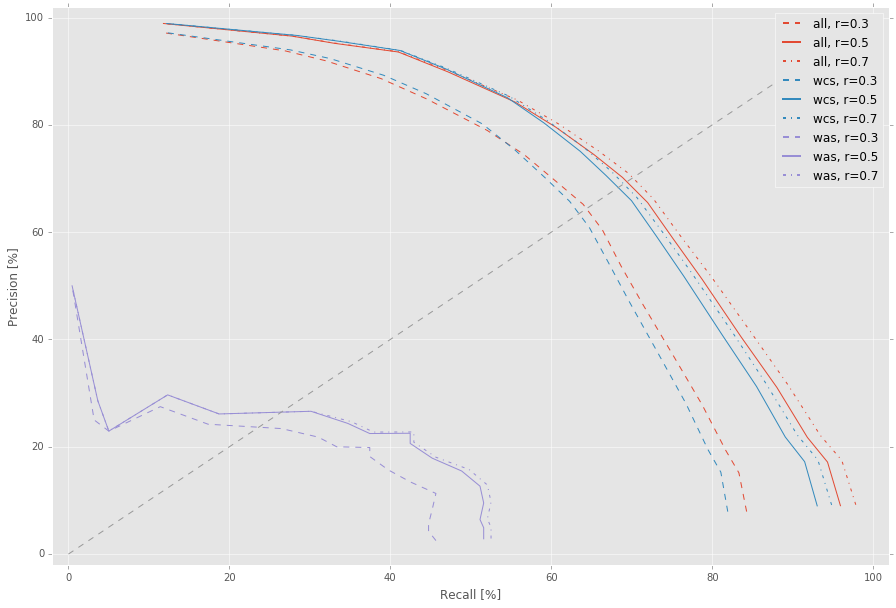

In [1152]:
plot_pr_curve(*precrecs_va);

### On reha

In [191]:
precrecs_re_05 = compute_precrecs(re_scans, pred_yre_conf, pred_yre_offs, re_wcs, re_was, rs=0.5)

.................

In [192]:
gen_precrec_csv('pr_reha', precrecs_re_05, radvals=None)

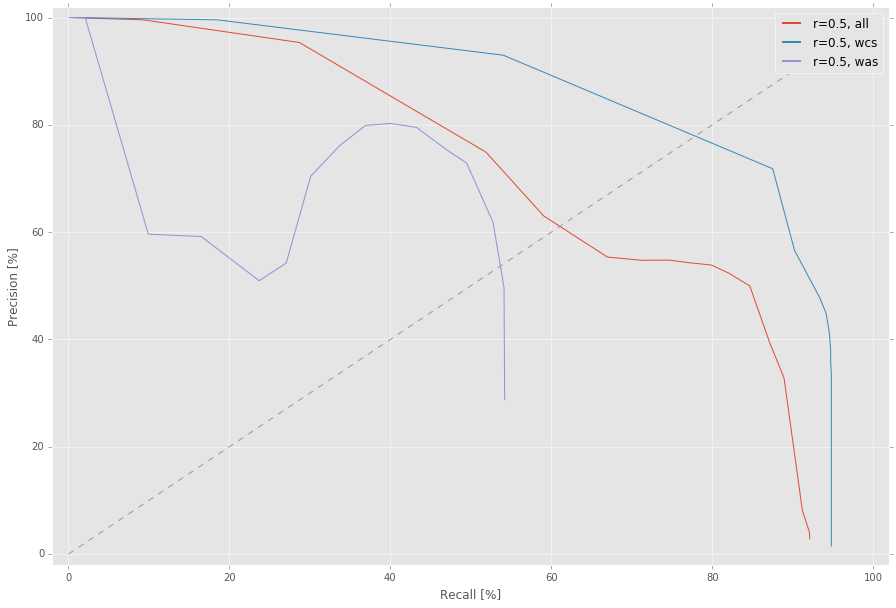

In [193]:
plot_pr_curve(*precrecs_re_05, radii=(0.5,));

### On Test

In [133]:
precrecs_te = compute_precrecs(te_scans, pred_yte_conf, pred_yte_offs, te_wcs, te_was)

.................

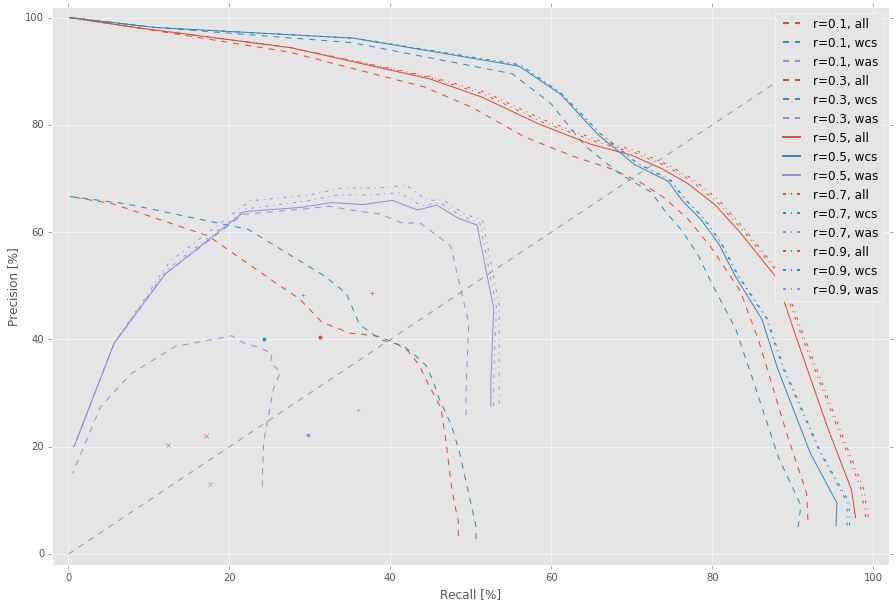

In [149]:
fig, ax = plot_pr_curve(*precrecs_te)

ax.scatter(0.17052136417091338, 0.22047643182970098, c='#E24A33', marker='x')
ax.scatter(0.31321050568404546, 0.40496705524581855, c='#E24A33')
ax.scatter(0.37671501372010974, 0.48707551951343131, c='#E24A33', marker='+')

ax.scatter(0.1233502538071066 , 0.20368818105616093, c='#348ABD', marker='x')
ax.scatter(0.24263959390862944, 0.40067057837384745, c='#348ABD')
ax.scatter(0.29187817258883247, 0.48197820620284998, c='#348ABD', marker='+')

ax.scatter(0.17555938037865748, 0.13076923076923078, c='#988ED5', marker='x')
ax.scatter(0.29776247848537007, 0.22179487179487178, c='#988ED5')
ax.scatter(0.35972461273666095, 0.26794871794871794, c='#988ED5', marker='+');

In [ ]:
gen_precrec_csv('pr_radii', precrecs_te)

In [168]:
precrecs_te_05 = compute_precrecs(te_scans, pred_yte_conf, pred_yte_offs, te_wcs, te_was, rs=0.5)

.................

In [170]:
gen_precrec_csv('pr_test', precrecs_te_05, radvals=None)

#### Over distances

In [265]:
def filterdets(dets, maxdist):
    return [[(r,phi) for r,phi in scandets if r < maxdist] for scandets in dets]

In [438]:
def compute_precrecs_maxdists(
    scans, pred_conf, pred_offs, gt_wcs, gt_was,
    ts=(1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1-1e-3, 1-1e-5),
    ds=1+np.arange(15),
    r=0.5
):
    gt_all = [wcs+was for wcs, was in zip(gt_wcs, gt_was)]

    mkgt = lambda: np.full((len(ts), len(ds)), np.nan)
    precs   , recs    = mkgt(), mkgt()
    precs_wc, recs_wc = mkgt(), mkgt()
    precs_wa, recs_wa = mkgt(), mkgt()

    for i, t in enumerate(ts):
        alldets, (wcdets, wadets) = pred2det_comb(scans, pred_conf, pred_offs, thresh=t, out_rphi=True)
        for j, d in enumerate(ds):
            precs[i,j], recs[i,j] = u.precrec(filterdets(alldets, d), filterdets(gt_all, d), r, pred_rphi=True, gt_rphi=True)
            precs_wc[i,j], recs_wc[i,j] = u.precrec(filterdets(wcdets, d), filterdets(gt_wcs, d), r, pred_rphi=True, gt_rphi=True)
            precs_wa[i,j], recs_wa[i,j] = u.precrec(filterdets(wadets, d), filterdets(gt_was, d), r, pred_rphi=True, gt_rphi=True)
        lbu.printnow(".")
    return (precs, recs), (precs_wc, recs_wc), (precs_wa, recs_wa)

precrecs_te_dists = compute_precrecs_maxdists(te_scans, pred_yte_conf, pred_yte_offs, te_wcs, te_was,
    ds=np.linspace(0.2, 15, 149),
    r=0.5
)

.................

In [450]:
precrecs_te_dists[1][0].shape

(17, 149)

In [458]:
def gen_precrec_dist_csv(name, precrecs,
    ts=(1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1-1e-3, 1-1e-5),
    ds=np.linspace(0.2, 15, 149)
):
    (p_all,r_all), (p_wc,r_wc), (p_wa,r_wa) = precrecs
    assert len(ts) == p_all.shape[0], "You forgot to update the `ts`"
    assert len(ds) == p_all.shape[1], "You forgot to update the `ds`"

    for i, t in enumerate(ts):
        with open(pjoin(REPORTDIR, "{}-{:f}.csv".format(name, t)), "wt+") as f:
            f.write("p_all,r_all,p_wc,r_wc,p_wa,r_wa\n")

            for j, d in enumerate(ds):
                f.write(','.join(["{:.1f}".format(100*p[i,j]) for p in (p_all,r_all,p_wc,r_wc,p_wa,r_wa)]))
                f.write('\n')

In [459]:
gen_precrec_dist_csv('pr_dist_test', precrecs_te_dists)

# Baselines/Ablation studies

Most of the other experiments in the paper were trivially done by making a copy of this notebook and changing some constant somewhere and just running everything again. This is left as an exercise to the very interested reader, of which there might even be none :)